# <div style="color:#1968b3;display:fill;border-radius:10px;background-color:white"><p style="color:#1968b3;padding:12px;text-align:center; font-size:150%"><b>FauxFinder DCGAN</b>

## 🎨 **A Deep Convolutional Generative Adversarial Network for Synthetic Art Creation**

The **FauxFinder DCGAN** is a deep learning framework designed to generate high-quality synthetic (fake) art images at a resolution of **256x256 pixels**. By leveraging the **Deep Convolutional Generative Adversarial Network (DCGAN)** architecture, this project explores the intersection of artificial intelligence and creativity, producing visually compelling fake art inspired by a dataset of real artworks.

---

### **Key Features of FauxFinder DCGAN**:
- **Resolution**: Generates images with a consistent size of **256x256 pixels**, ideal for visualization and downstream classification tasks.
- **Real Dataset**: Trained on a curated collection of <a href="https://www.kaggle.com/datasets/doctorstrange420/real-and-fake-ai-generated-art-images-dataset" style="color:#1968b3;text-decoration:underline;"><b>10,821 real art images</b></a>, resized and preprocessed for optimal learning.
- **Synthetic Dataset**: Creates an equal number of <a href="https://www.kaggle.com/datasets/doctorstrange420/real-and-fake-ai-generated-art-images-dataset" style="color:#1968b3;text-decoration:underline;"><b>10,821 AI-generated fake images</b></a> that mimic the styles and patterns of the real artworks.
- **Applications**: 
  - Art authenticity testing.
  - Style transfer and artistic exploration.
  - Dataset augmentation for classification models.
    
    
<p>
      ➡️ Learn more about the project by visiting the 
      <a href="https://github.com/Kaleemullah-Younas/FauxFinder-Real-vs-Fake-Art-Detection" style="color:#1968b3;text-decoration:underline;"><b>GitHub Repository</b></a>.</p>

<a id="section-one"></a>
# <div style="color:#1968b3;display:fill;border-radius:10px;background-color:white"><p style="padding:12px;color:#1968b3"><b>1 | Roadmap</b></div>

- [x] Enivronment Set-up
- [x] Building a data pipeline
- [x] Creating a generator and a discriminator
- [x] Building a custom training loop
- [x] Generating Fake images
- [x] Model performance

<a id="section-three"></a>
# <div style="color:#1968b3;display:fill;border-radius:10px;background-color:white"><p style="padding:12px;color:#1968b3"><b>2 | Import dependencies and Data Pre-processing</b></div>

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

In [2]:
# Bringing in tensorflow and limiting VRAM growth
# Only needed when running on local GPU
import tensorflow as tf
tf.get_logger().setLevel('INFO')

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
original_dataset_path = "/kaggle/input/art-images-dataset"
preprocessed_dataset_path = "/kaggle/working/processed_dataset"

os.makedirs(preprocessed_dataset_path, exist_ok=True)

IMG_SIZE = (256, 256)

print("Processing images...")
for root, _, files in os.walk(original_dataset_path):
    for file in tqdm(files):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Open the image
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert("RGB")
                # Resize to 256x256
                img = img.resize(IMG_SIZE)
                # Save to the new folder
                output_path = os.path.join(preprocessed_dataset_path, file)
                img.save(output_path)
            except Exception as e:
                print(f"Error processing {file}: {e}")

print(f"All images resized and saved to: {preprocessed_dataset_path}")

Processing images...


100%|██████████| 10821/10821 [00:49<00:00, 218.85it/s]

All images resized and saved to: /kaggle/working/processed_dataset


In [3]:
data_path = "/kaggle/working/processed_dataset"

In [4]:
batch_size = 32
image_height = 256
image_width = 256

# *shuffle and batch already done
ds = tf.keras.utils.image_dataset_from_directory(data_path, 
                                                       label_mode = None, 
                                                       image_size = (image_height, image_width), 
                                                       batch_size = batch_size)

Found 10821 files.


<a id="section-four"></a>
# <div style="color:#1968b3;display:fill;border-radius:10px;background-color:white"><p style="padding:12px;color:#1968b3"><b>3 | Visualising dataset</b></div>

In [5]:
# Function to display and save images
def show_images(data, save_path="displayed_images.png"):
    plt.figure(figsize=(12, 10))
    
    for images in data.take(1):
        for idx in range(12):
            plt.subplot(3, 4, idx+1)
            plt.imshow(images[idx].numpy().astype("uint8"))
            plt.axis("off")
    
    plt.tight_layout()
    plt.savefig(save_path, format="png", bbox_inches="tight")
    plt.show()

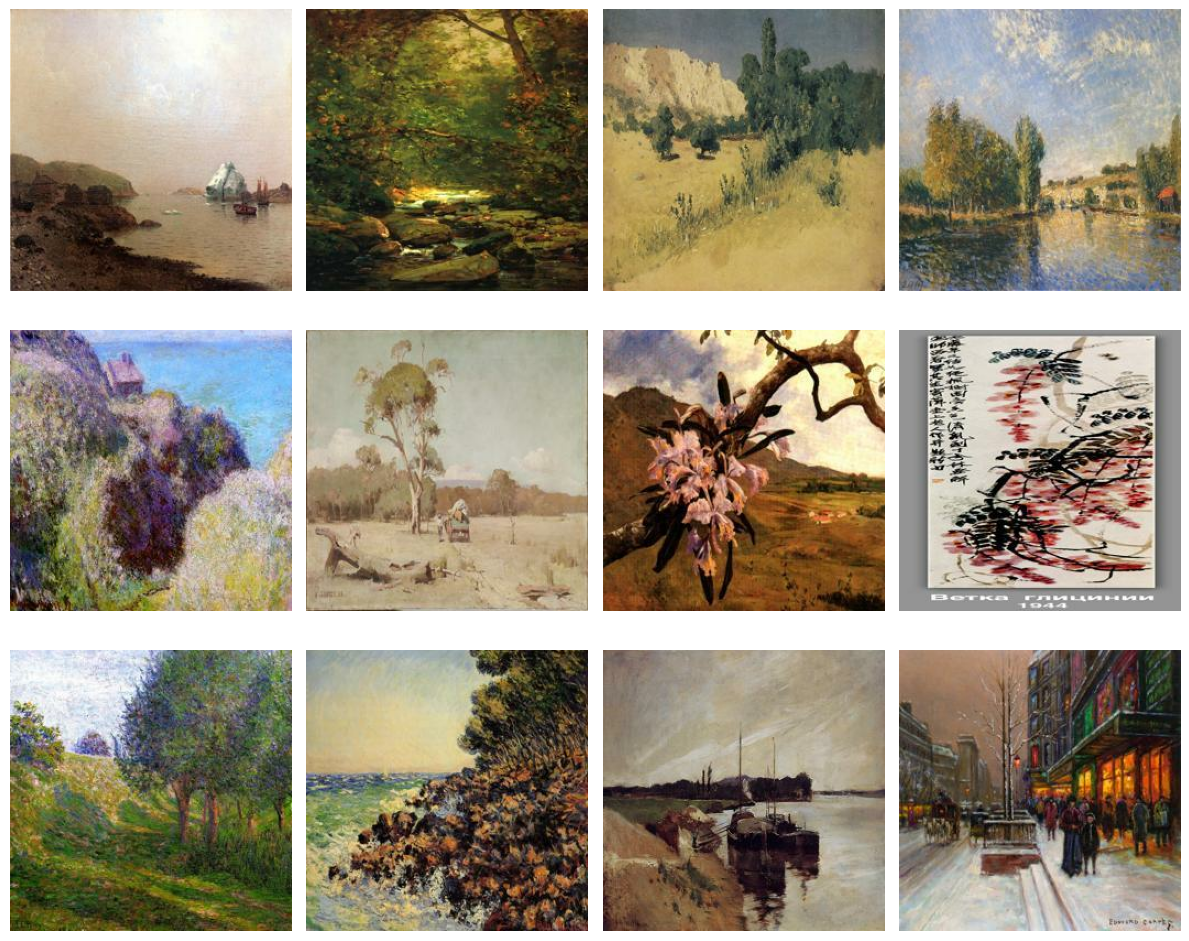

In [6]:
# Display dataset
show_images(ds)

In [7]:
# Data processing

# MCSBP process (map, cache, shuffle, batch, prefetch)

# map: scale values to be between 0 and 1
ds = ds.map(lambda x: x / 255.0)

In [8]:
# Printing something like torch.Size([batch_size, channels, height, width])
for batch in ds:
    if isinstance(batch, tuple):
        images = batch[0]
    else:
        images = batch

    print("Batch shape:", images.shape)  
    break  # Check only the first batch

Batch shape: (32, 256, 256, 3)


<a id="section-five"></a>
# <div style="color:#1968b3;display:fill;border-radius:10px;background-color:white"><p style="padding:12px;color:#1968b3"><b>4 | Creating DCGAN Components</b></div>

**Generator**

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator)
- Use batchnorm in both the generator and the discriminator
- Remove fully connected hidden layers for deeper architectures
- Use ReLU activation in generator
- Use LeakyReLU activation in the discriminator for all layers

---

**Discriminator**

The discriminator is simply a CNN based image classifier (real or fake).

In [9]:
# Importing modelling components

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, ZeroPadding2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Reshape, LeakyReLU, Dropout

In [10]:
# Build generator
latent_dim = 128

generator = Sequential()

# Block 1: Dense layer to reshape into a 4x4x256 tensor
generator.add(Dense(4 * 4 * 256, input_dim=latent_dim))
generator.add(Activation("relu"))
generator.add(Reshape((4, 4, 256)))

# Block 2: Upsample to 8x8
generator.add(UpSampling2D())
generator.add(Conv2D(256, 3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

# Block 3: Upsample to 16x16
generator.add(UpSampling2D())
generator.add(Conv2D(256, 3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

# Block 4: Upsample to 32x32
generator.add(UpSampling2D())
generator.add(Conv2D(256, 3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

# Block 5: Upsample to 64x64
generator.add(UpSampling2D())
generator.add(Conv2D(128, 3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

# Block 6: Upsample to 128x128
generator.add(UpSampling2D())
generator.add(Conv2D(128, 3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

# Block 7: Upsample to 256x256
generator.add(UpSampling2D())
generator.add(Conv2D(64, 3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))

# Final output: 256x256 RGB image
generator.add(Conv2D(3, 3, padding="same"))
generator.add(Activation("sigmoid"))

generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,821,123 (10.76 MB)

 Trainable params: 2,818,947 (10.75 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [11]:
summary_path = "generator_summary.png"
with open(summary_path, "w") as f:
    generator.summary(print_fn=lambda x: f.write(x + "\n"))

print(f"Discriminator summary saved to {summary_path}")

Discriminator summary saved to generator_summary.png


In [12]:
# Use the untrained generator to generate four images (random)

random_latent_vectors = tf.random.uniform((4, latent_dim))
generated_images = generator(random_latent_vectors, training = False)
generated_images.shape

TensorShape([4, 256, 256, 3])

In [13]:
# Visualizing and saving generated images without training
def visualize_and_save_images(generated_images, save_path="generated_images_visualization.png"):
    fig, ax = plt.subplots(ncols=4, figsize=(16, 16))
    for idx, img in enumerate(generated_images):
        if idx < 4:
            ax[idx].imshow(img[:, :, 0], cmap='gray') 
            ax[idx].axis("off")
    plt.tight_layout() 
    plt.savefig(save_path, format="png", bbox_inches="tight")
    plt.show()

    print(f"Visualization saved to {save_path}")

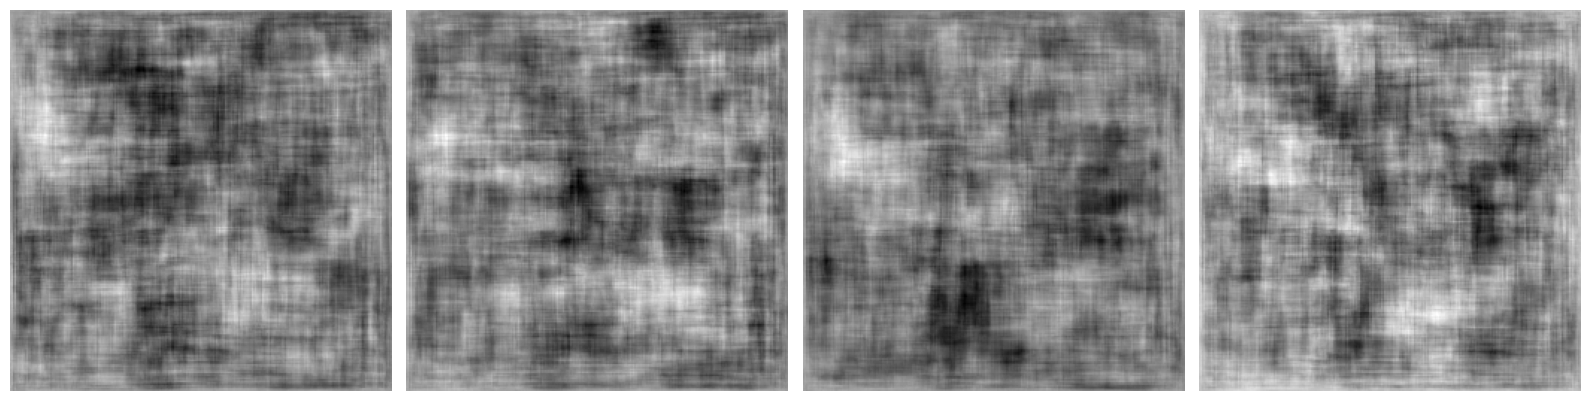

Visualization saved to generated_images_visualization.png


In [14]:
# Assuming `generated_images` is a NumPy array or Tensor of images
visualize_and_save_images(generated_images, save_path="generated_images_visualization.png")

In [15]:
# Build discriminator
discriminator = Sequential()

# Input: 256x256x3 images
discriminator.add(Conv2D(64, 3, 2, input_shape=(256, 256, 3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# Block 2: Downsample to 128x128
discriminator.add(Conv2D(128, 3, 2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# Block 3: Downsample to 64x64
discriminator.add(Conv2D(256, 3, 2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# Block 4: Downsample to 32x32
discriminator.add(Conv2D(512, 3, 2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# Block 5: Downsample to 16x16
discriminator.add(Conv2D(512, 3, 2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# Block 6: Downsample to 8x8
discriminator.add(Conv2D(512, 3, 2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# Block 7: Downsample to 4x4
discriminator.add(Conv2D(512, 3, 2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# Flatten and output
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,642,177 (32.97 MB)

 Trainable params: 8,637,313 (32.95 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [16]:
summary_path = "discriminator_summary.png"
with open(summary_path, "w") as f:
    discriminator.summary(print_fn=lambda x: f.write(x + "\n"))

print(f"Discriminator summary saved to {summary_path}")

Discriminator summary saved to discriminator_summary.png


In [17]:
# Classify a random generated image with the untrained discriminator
#   the prediction will likely be 50%

random_latent_vector = tf.random.uniform((1, latent_dim))
generated_image = generator(random_latent_vector, training = False)
print(discriminator(generated_image))

tf.Tensor([[0.497132]], shape=(1, 1), dtype=float32)


<a id="section-six"></a>
# <div style="color:#1968b3;display:fill;border-radius:10px;background-color:white"><p style="padding:12px;color:#1968b3"><b>5 | Construct training loop</b></div>

Training GANs is challenging because it requires balancing the learning speeds of the generator and discriminator. To help with this, we can inject random noise into the discriminator's output to slow it down.

#### GAN Training Steps:
- **Instantiate the model:**
  - Create the generator and discriminator models.
  - Compile them with a loss function (binary cross-entropy) and an optimizer (Adam).
  - Use a custom training loop instead of `model.fit` since GANs have two components to train simultaneously.

#### Loss Function:
- The generator’s output is an image, so we use binary cross-entropy to measure how well the discriminator identifies fake vs. real images.
- **Goal:**
  - **Generator:** Reward it for tricking the discriminator.
  - **Discriminator:** Reward it for accurately classifying real vs. fake images.

<a id="subsection-one"></a>
## <b><span style='color:#1968b3'>5.1</span> | Setup losses and optimisers</b>

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

g_opt = Adam(learning_rate = 1.2e-4, beta_1 = 0.5) 
d_opt = Adam(learning_rate = 1e-4, beta_1 = 0.5)

g_loss_fn = BinaryCrossentropy()
d_loss_fn = BinaryCrossentropy()

<a id="subsection-two"></a>
## <b><span style='color:#1968b3'>5.2</span> | Build subclassed model</b>

In [19]:
# Import base model class to subclass our training step

from tensorflow.keras.models import Model

# We need to define three key methods when subclassing 
#   from the Model class: init, train (.fit), and compile
class ArtGAN(Model):
    
    def __init__(self, generator, discriminator, latent_dim):
        super(ArtGAN, self).__init__()

        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    # Compile with base class
    def compile(self, g_opt, d_opt, g_loss_fn, d_loss_fn):
        super(ArtGAN, self).compile()

        self.g_opt = g_opt
        self.d_opt = d_opt
        
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        
        self.g_loss_metric = tf.keras.metrics.Mean(name = "g_loss")
        self.d_loss_metric = tf.keras.metrics.Mean(name = "d_loss")
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    # Called when we call .fit function
    # batch = real images
    def train_step(self, batch):

        # Get data
        batch_size = tf.shape(batch)[0]
        real_images = batch
        
        # Generate batch_size images, so we have same number of images in real and fake batch
        random_latent_vectors = tf.random.normal((batch_size, self.latent_dim))
        fake_images = self.generator(random_latent_vectors)
        
        # Combined images
        combined_images = tf.concat([fake_images, real_images], axis = 0)
        
        # Create labels for real and fake images
        # At the moment it is a supervised learning problem (fake or not fake)
        # Effectively, batch_size zeros (real) and batch_size ones (fake)
        # actual labels
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis = 0)

        # Add noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        # Train discriminator
        with tf.GradientTape() as d_tape:
            
            # Discriminator predictions   
            predictions = self.discriminator(combined_images)
            
            # Calculate loss - BinaryCrossentropy
            d_loss = self.d_loss_fn(labels, predictions)

        # Apply backpropagation - NN learn
        # Calculate gradient for each one of our trainable variables with respect to our loss
        dgrad = d_tape.gradient(d_loss, self.discriminator.trainable_variables) 
        
        # Apply gradients using our optimizer
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # -------------------------------------------------------------------------------
        
        # Generate new images
        random_latent_vectors = tf.random.normal((batch_size, self.latent_dim))
        
        # Since we are trying to trick our discriminator, what we are going to do 
        #   is set the variables for our generator to zero. In other words, we want 
        #   our discriminator to think that the generated images are real images

        # Create misleading labels (all real images)
        misleading_labels = tf.zeros((batch_size, 1))
        
        # Train generator
        with tf.GradientTape() as g_tape:
            
            # Create the predicted labels
            predictions = self.discriminator(self.generator(random_latent_vectors))
            
            # Calculate loss - BinaryCrossentropy - trick using misleading_labels 
            g_loss = self.g_loss_fn(misleading_labels, predictions)
            
        # Apply backpropagation - NN learn
        # Calculate gradient for each one of our trainable variables with respect to our loss
        ggrad = g_tape.gradient(g_loss, self.generator.trainable_variables) 
        
        # Apply gradients using our optimizer
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        # Update
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [20]:
# number of epochs
epochs = 150

# instance of subclassed model
model = ArtGAN(generator = generator, discriminator = discriminator, latent_dim = latent_dim)

# Compile the model
model.compile(g_opt = g_opt, d_opt = d_opt, g_loss_fn = g_loss_fn, d_loss_fn = d_loss_fn)

<a id="subsection-three"></a>
## <b><span style='color:#1968b3'>5.3</span> | Build callback</b>

In [21]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

# Callback to save generated image on epoch end
class ModelMonitor(Callback):
    def __init__(self, num_img = 1, latent_dim = latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    # Saving generated image at the end of each epoch 
    def on_epoch_end(self, epoch, logs = None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}.png'))

<a id="subsection-four"></a>
## <b><span style='color:#1968b3'>5.4</span> | Train</b>

In [24]:
hist = model.fit(ds, epochs = epochs, callbacks=[ModelMonitor()])

Epoch 1/150


Cleanup called...


 4/65 [>.............................] - ETA: 16s - d_loss: 0.6723 - g_loss: 0.8530

Cleanup called...


11/65 [====>.........................] - ETA: 28s - d_loss: 0.6816 - g_loss: 0.7585

Cleanup called...


13/65 [=====>........................] - ETA: 27s - d_loss: 0.6757 - g_loss: 0.7616

Cleanup called...


14/65 [=====>........................] - ETA: 27s - d_loss: 0.6685 - g_loss: 0.7728

Cleanup called...


24/65 [==========>...................] - ETA: 25s - d_loss: 0.6700 - g_loss: 0.7928

Cleanup called...


38/65 [================>.............] - ETA: 17s - d_loss: 0.5790 - g_loss: 0.7948

Cleanup called...


44/65 [===================>..........] - ETA: 13s - d_loss: 0.5321 - g_loss: 0.8841

Cleanup called...


49/65 [=====================>........] - ETA: 10s - d_loss: 0.4851 - g_loss: 1.1390

Cleanup called...


65/65 [==============================] - 46s 593ms/step - d_loss: 0.4967 - g_loss: 1.7204
Epoch 2/150
 1/65 [..............................] - ETA: 5:15 - d_loss: 0.5617 - g_loss: 1.2792

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6113 - g_loss: 1.3484

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6765 - g_loss: 1.1001

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6756 - g_loss: 1.0776

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6764 - g_loss: 1.0464

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.7050 - g_loss: 0.9141

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.7164 - g_loss: 0.8513

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.7136 - g_loss: 0.8539

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.7123 - g_loss: 0.8682

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.7120 - g_loss: 0.8538
Epoch 3/150
 1/65 [..............................] - ETA: 4:56 - d_loss: 0.7170 - g_loss: 0.7805

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.7020 - g_loss: 0.7297

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6866 - g_loss: 0.7984

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6837 - g_loss: 0.7871

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6820 - g_loss: 0.7769

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6814 - g_loss: 0.7700

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6795 - g_loss: 0.7770

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6740 - g_loss: 0.7905

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6727 - g_loss: 0.8055

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6743 - g_loss: 0.8638
Epoch 4/150
 1/65 [..............................] - ETA: 5:08 - d_loss: 0.6183 - g_loss: 1.1360

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6646 - g_loss: 0.9944

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6455 - g_loss: 0.9319

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6396 - g_loss: 0.9338

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6372 - g_loss: 0.9320

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6335 - g_loss: 0.9349

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6492 - g_loss: 0.9530

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6634 - g_loss: 0.9444

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6701 - g_loss: 0.9363

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6721 - g_loss: 0.9147
Epoch 5/150
 1/65 [..............................] - ETA: 4:50 - d_loss: 0.6629 - g_loss: 0.8250

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6671 - g_loss: 0.7707

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6622 - g_loss: 0.7833

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6598 - g_loss: 0.7953

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6579 - g_loss: 0.8043

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6538 - g_loss: 0.8391

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6563 - g_loss: 0.8575

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6631 - g_loss: 0.8441

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6676 - g_loss: 0.8394

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6709 - g_loss: 0.8374
Epoch 6/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.6620 - g_loss: 1.0217

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6856 - g_loss: 0.8469

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6901 - g_loss: 0.8068

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6875 - g_loss: 0.7850

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6870 - g_loss: 0.7840

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6747 - g_loss: 0.8233

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6700 - g_loss: 0.8301

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6697 - g_loss: 0.8478

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6627 - g_loss: 0.8879

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6379 - g_loss: 1.1468
Epoch 7/150
 1/65 [..............................] - ETA: 5:05 - d_loss: 0.3623 - g_loss: 2.3565

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.4229 - g_loss: 2.1650

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6052 - g_loss: 1.3798

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6168 - g_loss: 1.3117

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6207 - g_loss: 1.2721

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6356 - g_loss: 1.0748

Cleanup called...


38/65 [================>.............] - ETA: 15s - d_loss: 0.6657 - g_loss: 0.9623

Cleanup called...


44/65 [===================>..........] - ETA: 11s - d_loss: 0.6663 - g_loss: 0.9424

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6633 - g_loss: 0.9275

Cleanup called...


65/65 [==============================] - 37s 497ms/step - d_loss: 0.6670 - g_loss: 0.8963
Epoch 8/150
 1/65 [..............................] - ETA: 5:03 - d_loss: 0.7101 - g_loss: 0.6977

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6917 - g_loss: 0.8706

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6751 - g_loss: 0.8692

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6776 - g_loss: 0.8643

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6774 - g_loss: 0.8756

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6669 - g_loss: 0.8978

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6717 - g_loss: 0.9024

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.6695 - g_loss: 0.9064

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6684 - g_loss: 0.8982

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.6687 - g_loss: 0.8806
Epoch 9/150
 1/65 [..............................] - ETA: 5:27 - d_loss: 0.6862 - g_loss: 0.8719

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6802 - g_loss: 0.8049

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6751 - g_loss: 0.8225

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6710 - g_loss: 0.8235

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6721 - g_loss: 0.8353

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6711 - g_loss: 0.9197

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6639 - g_loss: 0.9055

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6665 - g_loss: 0.9155

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6675 - g_loss: 0.9047

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6675 - g_loss: 0.9044
Epoch 10/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6884 - g_loss: 0.8186

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6924 - g_loss: 0.9254

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6590 - g_loss: 0.9322

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6590 - g_loss: 0.9089

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6580 - g_loss: 0.9049

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6572 - g_loss: 0.8852

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6524 - g_loss: 0.9073

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6497 - g_loss: 0.9238

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6594 - g_loss: 0.9721

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6644 - g_loss: 0.9389
Epoch 11/150
 1/65 [..............................] - ETA: 4:59 - d_loss: 0.6463 - g_loss: 0.9571

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6395 - g_loss: 0.9691

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6474 - g_loss: 0.8505

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6498 - g_loss: 0.8338

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6508 - g_loss: 0.8343

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6362 - g_loss: 0.8618

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6308 - g_loss: 0.8769

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6311 - g_loss: 0.8862

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6306 - g_loss: 0.8764

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.6387 - g_loss: 0.9150
Epoch 12/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.5547 - g_loss: 0.9161

Cleanup called...


 4/65 [>.............................] - ETA: 39s - d_loss: 0.6397 - g_loss: 1.1260

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6085 - g_loss: 1.1147

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6135 - g_loss: 1.0754

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6187 - g_loss: 1.0497

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6390 - g_loss: 1.0194

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6383 - g_loss: 0.9987

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6433 - g_loss: 0.9561

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6445 - g_loss: 0.9726

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6407 - g_loss: 0.9614
Epoch 13/150
 1/65 [..............................] - ETA: 5:34 - d_loss: 0.6486 - g_loss: 0.8170

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6491 - g_loss: 0.8108

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6464 - g_loss: 1.0859

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6472 - g_loss: 1.0599

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6519 - g_loss: 1.0315

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6483 - g_loss: 0.9431

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6558 - g_loss: 0.9189

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6536 - g_loss: 0.9400

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6564 - g_loss: 0.9255

Cleanup called...


65/65 [==============================] - 34s 445ms/step - d_loss: 0.6565 - g_loss: 0.9186
Epoch 14/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.6968 - g_loss: 0.7436

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6787 - g_loss: 0.7569

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6673 - g_loss: 0.9187

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6618 - g_loss: 0.9513

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6604 - g_loss: 0.9469

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6614 - g_loss: 0.8975

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6551 - g_loss: 0.9059

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6577 - g_loss: 0.9005

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6666 - g_loss: 0.9147

Cleanup called...


65/65 [==============================] - 33s 453ms/step - d_loss: 0.6694 - g_loss: 0.8900
Epoch 15/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6852 - g_loss: 0.7143

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6805 - g_loss: 0.7442

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6768 - g_loss: 0.8235

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6757 - g_loss: 0.8146

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6743 - g_loss: 0.8071

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6720 - g_loss: 0.8103

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6789 - g_loss: 0.8173

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6789 - g_loss: 0.8175

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6760 - g_loss: 0.8263

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6793 - g_loss: 0.8201
Epoch 16/150
 1/65 [..............................] - ETA: 5:03 - d_loss: 0.6801 - g_loss: 0.7017

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6788 - g_loss: 0.7304

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6860 - g_loss: 0.8348

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6879 - g_loss: 0.8177

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6876 - g_loss: 0.8109

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6796 - g_loss: 0.7802

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6808 - g_loss: 0.7974

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6804 - g_loss: 0.7934 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6797 - g_loss: 0.7919

Cleanup called...


65/65 [==============================] - 34s 452ms/step - d_loss: 0.6809 - g_loss: 0.7981
Epoch 17/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6881 - g_loss: 0.6814

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6828 - g_loss: 0.7761

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6692 - g_loss: 0.8412

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6703 - g_loss: 0.8184

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6717 - g_loss: 0.8065

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6780 - g_loss: 0.8108

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6794 - g_loss: 0.8058

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6811 - g_loss: 0.8015

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6810 - g_loss: 0.8041

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6806 - g_loss: 0.7990
Epoch 18/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6582 - g_loss: 0.7227

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6847 - g_loss: 0.7096

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6869 - g_loss: 0.8212

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6857 - g_loss: 0.8131

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6845 - g_loss: 0.8085

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6784 - g_loss: 0.7956

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6792 - g_loss: 0.8083

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6768 - g_loss: 0.7988

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6786 - g_loss: 0.7973

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6769 - g_loss: 0.8071
Epoch 19/150
 1/65 [..............................] - ETA: 5:01 - d_loss: 0.7299 - g_loss: 0.7474

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6962 - g_loss: 0.7720

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6766 - g_loss: 0.8521

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6767 - g_loss: 0.8586

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6772 - g_loss: 0.8559

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6782 - g_loss: 0.8156

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6807 - g_loss: 0.8315

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.6807 - g_loss: 0.8154

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6817 - g_loss: 0.8119

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6801 - g_loss: 0.8111
Epoch 20/150
 1/65 [..............................] - ETA: 5:37 - d_loss: 0.6465 - g_loss: 0.8665

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6492 - g_loss: 0.8481

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6811 - g_loss: 0.7619

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6807 - g_loss: 0.7860

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6789 - g_loss: 0.7965

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6812 - g_loss: 0.8129

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6799 - g_loss: 0.7993

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6791 - g_loss: 0.8010 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6792 - g_loss: 0.8037

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6785 - g_loss: 0.8044
Epoch 21/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6890 - g_loss: 0.7366

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.7011 - g_loss: 0.7948

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6845 - g_loss: 0.8132

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6806 - g_loss: 0.7938

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6802 - g_loss: 0.7864

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6829 - g_loss: 0.7922

Cleanup called...


38/65 [================>.............] - ETA: 14s - d_loss: 0.6838 - g_loss: 0.7837

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6840 - g_loss: 0.7786

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6833 - g_loss: 0.7864

Cleanup called...


65/65 [==============================] - 35s 472ms/step - d_loss: 0.6842 - g_loss: 0.7782
Epoch 22/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.6832 - g_loss: 0.7900

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6850 - g_loss: 0.7991

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6851 - g_loss: 0.7628

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6853 - g_loss: 0.7551

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6849 - g_loss: 0.7525

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6865 - g_loss: 0.7626

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6859 - g_loss: 0.7616

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6864 - g_loss: 0.7603 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6864 - g_loss: 0.7606

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6859 - g_loss: 0.7650
Epoch 23/150
 1/65 [..............................] - ETA: 5:40 - d_loss: 0.6977 - g_loss: 0.7302

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6913 - g_loss: 0.7141

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6854 - g_loss: 0.7416

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6881 - g_loss: 0.7511

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6885 - g_loss: 0.7610

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6820 - g_loss: 0.7832

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6861 - g_loss: 0.7944

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6831 - g_loss: 0.7827

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6818 - g_loss: 0.7877

Cleanup called...


65/65 [==============================] - 34s 445ms/step - d_loss: 0.6801 - g_loss: 0.7875
Epoch 24/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6997 - g_loss: 0.9715

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.7087 - g_loss: 0.9496

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6904 - g_loss: 0.8805

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6888 - g_loss: 0.8608

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6887 - g_loss: 0.8508

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6881 - g_loss: 0.7982

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6873 - g_loss: 0.7904

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6852 - g_loss: 0.7803

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6859 - g_loss: 0.7833

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6856 - g_loss: 0.7809
Epoch 25/150
 1/65 [..............................] - ETA: 4:44 - d_loss: 0.6740 - g_loss: 0.7387

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6780 - g_loss: 0.7259

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6872 - g_loss: 0.7580

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6831 - g_loss: 0.7801

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6827 - g_loss: 0.7847

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6859 - g_loss: 0.7680

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6837 - g_loss: 0.7929

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6825 - g_loss: 0.7863

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6834 - g_loss: 0.7816

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6829 - g_loss: 0.7791
Epoch 26/150
 1/65 [..............................] - ETA: 5:04 - d_loss: 0.6756 - g_loss: 0.7938

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6856 - g_loss: 0.8041

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6841 - g_loss: 0.7866

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6832 - g_loss: 0.7800

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6835 - g_loss: 0.7774

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6819 - g_loss: 0.7699

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6807 - g_loss: 0.7756

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6809 - g_loss: 0.7720

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6812 - g_loss: 0.7751

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6813 - g_loss: 0.7756
Epoch 27/150
 1/65 [..............................] - ETA: 5:01 - d_loss: 0.6706 - g_loss: 0.7385

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6752 - g_loss: 0.7083

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6799 - g_loss: 0.7719

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6794 - g_loss: 0.7733

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6789 - g_loss: 0.7715

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6783 - g_loss: 0.7671

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6788 - g_loss: 0.7733

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6790 - g_loss: 0.7817

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6781 - g_loss: 0.7794

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.6785 - g_loss: 0.7825
Epoch 28/150
 1/65 [..............................] - ETA: 4:45 - d_loss: 0.6665 - g_loss: 0.8178

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6723 - g_loss: 0.8253

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6794 - g_loss: 0.8217

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6788 - g_loss: 0.8141

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6792 - g_loss: 0.8089

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6799 - g_loss: 0.7922

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6806 - g_loss: 0.7900

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6802 - g_loss: 0.7841

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6796 - g_loss: 0.7884

Cleanup called...


65/65 [==============================] - 34s 464ms/step - d_loss: 0.6797 - g_loss: 0.7876
Epoch 29/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.6835 - g_loss: 0.7318

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.6849 - g_loss: 0.7333

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6803 - g_loss: 0.7735

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6794 - g_loss: 0.7789

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6796 - g_loss: 0.7807

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6812 - g_loss: 0.7779

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6794 - g_loss: 0.7901

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6780 - g_loss: 0.7894

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6787 - g_loss: 0.7925

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.6784 - g_loss: 0.7855
Epoch 30/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.6859 - g_loss: 0.7577

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6814 - g_loss: 0.8154

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6818 - g_loss: 0.8077

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6829 - g_loss: 0.8016

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6830 - g_loss: 0.7966

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6787 - g_loss: 0.7769

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6788 - g_loss: 0.7923

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6790 - g_loss: 0.7881 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6775 - g_loss: 0.7961

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6774 - g_loss: 0.8096
Epoch 31/150
 1/65 [..............................] - ETA: 5:05 - d_loss: 0.6834 - g_loss: 0.7966

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6828 - g_loss: 0.7627

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6787 - g_loss: 0.7475

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6800 - g_loss: 0.7509

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6798 - g_loss: 0.7575

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6805 - g_loss: 0.7707

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6800 - g_loss: 0.7698

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6791 - g_loss: 0.7681

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6779 - g_loss: 0.7708

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.6786 - g_loss: 0.7776
Epoch 32/150
 1/65 [..............................] - ETA: 5:04 - d_loss: 0.6686 - g_loss: 0.7338

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6944 - g_loss: 0.7685

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6905 - g_loss: 0.8358

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6870 - g_loss: 0.8187

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6845 - g_loss: 0.8118

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6824 - g_loss: 0.8005

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6793 - g_loss: 0.7854

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6795 - g_loss: 0.7872

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6788 - g_loss: 0.7972

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6778 - g_loss: 0.8046
Epoch 33/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6585 - g_loss: 1.0329

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6815 - g_loss: 0.9056

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6791 - g_loss: 0.7788

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6778 - g_loss: 0.7620

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6786 - g_loss: 0.7593

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6784 - g_loss: 0.7950

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6784 - g_loss: 0.7807

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6775 - g_loss: 0.7862

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6780 - g_loss: 0.7840

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6779 - g_loss: 0.7879
Epoch 34/150
 1/65 [..............................] - ETA: 5:20 - d_loss: 0.6844 - g_loss: 0.8104

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6713 - g_loss: 0.7682

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6763 - g_loss: 0.7947

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6775 - g_loss: 0.8113

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6800 - g_loss: 0.8098

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6812 - g_loss: 0.7764

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6808 - g_loss: 0.7820

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6785 - g_loss: 0.7865

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6791 - g_loss: 0.7895

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6787 - g_loss: 0.7915
Epoch 35/150
 1/65 [..............................] - ETA: 5:09 - d_loss: 0.6898 - g_loss: 0.8639

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6790 - g_loss: 0.8870

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6783 - g_loss: 0.8076

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6775 - g_loss: 0.7910

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6779 - g_loss: 0.7862

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6769 - g_loss: 0.7791

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6761 - g_loss: 0.7904

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6774 - g_loss: 0.7920

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6755 - g_loss: 0.7931

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6756 - g_loss: 0.7951
Epoch 36/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.6887 - g_loss: 0.7400

Cleanup called...


 4/65 [>.............................] - ETA: 27s - d_loss: 0.6749 - g_loss: 0.7903

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6794 - g_loss: 0.7871

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6781 - g_loss: 0.7860

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6779 - g_loss: 0.7863

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6751 - g_loss: 0.7951

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6756 - g_loss: 0.7891

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6757 - g_loss: 0.7983

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6755 - g_loss: 0.7936

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6762 - g_loss: 0.7901
Epoch 37/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6905 - g_loss: 0.8610

Cleanup called...


 4/65 [>.............................] - ETA: 34s - d_loss: 0.6798 - g_loss: 0.9999

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6830 - g_loss: 0.8643

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6777 - g_loss: 0.8402

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6746 - g_loss: 0.8261

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6830 - g_loss: 0.8197

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6788 - g_loss: 0.7915

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6778 - g_loss: 0.7954

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6785 - g_loss: 0.7975

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6773 - g_loss: 0.7976
Epoch 38/150
 1/65 [..............................] - ETA: 4:49 - d_loss: 0.6945 - g_loss: 0.7739

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6714 - g_loss: 0.7791

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6732 - g_loss: 0.7845

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6727 - g_loss: 0.7871

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6738 - g_loss: 0.7876

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6761 - g_loss: 0.7835

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6774 - g_loss: 0.7845

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6764 - g_loss: 0.7821

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6769 - g_loss: 0.7814

Cleanup called...


65/65 [==============================] - 33s 452ms/step - d_loss: 0.6768 - g_loss: 0.7867
Epoch 39/150
 1/65 [..............................] - ETA: 5:02 - d_loss: 0.6719 - g_loss: 0.7793

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6800 - g_loss: 0.7950

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6838 - g_loss: 0.7941

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6834 - g_loss: 0.7864

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6839 - g_loss: 0.7831

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6813 - g_loss: 0.7894

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6788 - g_loss: 0.7908

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6792 - g_loss: 0.7927 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6790 - g_loss: 0.7901

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6768 - g_loss: 0.7935
Epoch 40/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6598 - g_loss: 0.8682

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6671 - g_loss: 0.8156

Cleanup called...


11/65 [====>.........................] - ETA: 28s - d_loss: 0.6734 - g_loss: 0.8130

Cleanup called...


13/65 [=====>........................] - ETA: 26s - d_loss: 0.6743 - g_loss: 0.8112

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6742 - g_loss: 0.8097

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6760 - g_loss: 0.8090

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6775 - g_loss: 0.8056

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6765 - g_loss: 0.8015

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6752 - g_loss: 0.8139

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6762 - g_loss: 0.8079
Epoch 41/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.6615 - g_loss: 0.7849

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6723 - g_loss: 0.8232

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6816 - g_loss: 0.8330

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6806 - g_loss: 0.8199

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6793 - g_loss: 0.8134

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6784 - g_loss: 0.8006

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6767 - g_loss: 0.7959

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6767 - g_loss: 0.7964

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6768 - g_loss: 0.8010

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6768 - g_loss: 0.7981
Epoch 42/150
 1/65 [..............................] - ETA: 5:06 - d_loss: 0.6854 - g_loss: 0.7863

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6729 - g_loss: 0.8262

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6803 - g_loss: 0.8260

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6774 - g_loss: 0.8163

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6751 - g_loss: 0.8116

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6743 - g_loss: 0.8157

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6723 - g_loss: 0.8168

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6739 - g_loss: 0.8215

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6735 - g_loss: 0.8184

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6746 - g_loss: 0.8130
Epoch 43/150
 1/65 [..............................] - ETA: 5:01 - d_loss: 0.6707 - g_loss: 0.7580

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6770 - g_loss: 0.7792

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6774 - g_loss: 0.8109

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6785 - g_loss: 0.8062

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6782 - g_loss: 0.8079

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6749 - g_loss: 0.8145

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6760 - g_loss: 0.8211

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6758 - g_loss: 0.8163

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6738 - g_loss: 0.8160

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6748 - g_loss: 0.8070
Epoch 44/150
 1/65 [..............................] - ETA: 5:24 - d_loss: 0.6880 - g_loss: 1.0116

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6774 - g_loss: 1.0531

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6810 - g_loss: 0.8663

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6777 - g_loss: 0.8535

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6771 - g_loss: 0.8480

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6753 - g_loss: 0.8231

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6749 - g_loss: 0.8189

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6761 - g_loss: 0.8295

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6759 - g_loss: 0.8199

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6751 - g_loss: 0.8133
Epoch 45/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6713 - g_loss: 0.8423

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6739 - g_loss: 0.8303

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6793 - g_loss: 0.8084

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6797 - g_loss: 0.8104

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6791 - g_loss: 0.8133

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6760 - g_loss: 0.8042

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6751 - g_loss: 0.8161

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6758 - g_loss: 0.8116

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6744 - g_loss: 0.8113

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6738 - g_loss: 0.8121
Epoch 46/150
 1/65 [..............................] - ETA: 5:02 - d_loss: 0.7029 - g_loss: 0.7974

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6570 - g_loss: 0.9830

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6738 - g_loss: 0.8429

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6781 - g_loss: 0.8381

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6792 - g_loss: 0.8347

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6801 - g_loss: 0.8285

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6801 - g_loss: 0.8108

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6784 - g_loss: 0.8012 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6781 - g_loss: 0.8045

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.6772 - g_loss: 0.8137
Epoch 47/150
 1/65 [..............................] - ETA: 4:52 - d_loss: 0.6449 - g_loss: 0.7600

Cleanup called...


 4/65 [>.............................] - ETA: 40s - d_loss: 0.6605 - g_loss: 0.7543

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6752 - g_loss: 0.8261

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6752 - g_loss: 0.8202

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6741 - g_loss: 0.8160

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6716 - g_loss: 0.8314

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6738 - g_loss: 0.8036

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6744 - g_loss: 0.8085

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6751 - g_loss: 0.8072

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6730 - g_loss: 0.8091
Epoch 48/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.6960 - g_loss: 0.7200

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6769 - g_loss: 0.8653

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6888 - g_loss: 0.8306

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6872 - g_loss: 0.8207

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6872 - g_loss: 0.8164

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6774 - g_loss: 0.8056

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6793 - g_loss: 0.8003

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6779 - g_loss: 0.8059

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6765 - g_loss: 0.7999

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6773 - g_loss: 0.8042
Epoch 49/150
 1/65 [..............................] - ETA: 5:02 - d_loss: 0.6505 - g_loss: 0.8897

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6626 - g_loss: 0.8469

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6683 - g_loss: 0.7767

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6711 - g_loss: 0.7808

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6723 - g_loss: 0.7857

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6742 - g_loss: 0.7887

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6734 - g_loss: 0.7996

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6748 - g_loss: 0.7969

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6753 - g_loss: 0.8005

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6743 - g_loss: 0.8051
Epoch 50/150
 1/65 [..............................] - ETA: 5:07 - d_loss: 0.6682 - g_loss: 0.8286

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6603 - g_loss: 0.8382

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6626 - g_loss: 0.8020

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6641 - g_loss: 0.8198

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6640 - g_loss: 0.8234

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6710 - g_loss: 0.8131

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6720 - g_loss: 0.8201

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6706 - g_loss: 0.8194

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6709 - g_loss: 0.8152

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6726 - g_loss: 0.8178
Epoch 51/150
 1/65 [..............................] - ETA: 4:59 - d_loss: 0.6651 - g_loss: 0.8670

Cleanup called...


 4/65 [>.............................] - ETA: 35s - d_loss: 0.6795 - g_loss: 0.8207

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6704 - g_loss: 0.7723

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6716 - g_loss: 0.7772

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6711 - g_loss: 0.7787

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6725 - g_loss: 0.7957

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6739 - g_loss: 0.8028

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6747 - g_loss: 0.8015

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6739 - g_loss: 0.8015

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6751 - g_loss: 0.8003
Epoch 52/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.6790 - g_loss: 0.7595

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.6651 - g_loss: 0.8306

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.6573 - g_loss: 0.8650

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6729 - g_loss: 0.8894

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6731 - g_loss: 0.8975

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6768 - g_loss: 0.8508

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6745 - g_loss: 0.8364

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6745 - g_loss: 0.8377 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6745 - g_loss: 0.8367

Cleanup called...


65/65 [==============================] - 34s 462ms/step - d_loss: 0.6745 - g_loss: 0.8270
Epoch 53/150
 1/65 [..............................] - ETA: 4:50 - d_loss: 0.6826 - g_loss: 0.8080

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6880 - g_loss: 0.8062

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6814 - g_loss: 0.8047

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6794 - g_loss: 0.7930

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6783 - g_loss: 0.7890

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6778 - g_loss: 0.7922

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6789 - g_loss: 0.8022

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6776 - g_loss: 0.7995

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6782 - g_loss: 0.8031

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6784 - g_loss: 0.7997
Epoch 54/150
 1/65 [..............................] - ETA: 5:09 - d_loss: 0.6973 - g_loss: 0.8173

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6841 - g_loss: 0.8045

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6829 - g_loss: 0.7794

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6814 - g_loss: 0.7892

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6810 - g_loss: 0.7908

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6783 - g_loss: 0.7952

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6781 - g_loss: 0.7939

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6779 - g_loss: 0.7963

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6781 - g_loss: 0.7993

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6772 - g_loss: 0.8008
Epoch 55/150
 1/65 [..............................] - ETA: 5:04 - d_loss: 0.6845 - g_loss: 0.8328

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6822 - g_loss: 0.8425

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6824 - g_loss: 0.7923

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6807 - g_loss: 0.7875

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6805 - g_loss: 0.7878

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6782 - g_loss: 0.7889

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6770 - g_loss: 0.7984

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6786 - g_loss: 0.8062 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6764 - g_loss: 0.8087

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6750 - g_loss: 0.8068
Epoch 56/150
 1/65 [..............................] - ETA: 4:49 - d_loss: 0.6738 - g_loss: 0.8875

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6557 - g_loss: 0.8642

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6771 - g_loss: 0.8332

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6820 - g_loss: 0.8227

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6817 - g_loss: 0.8247

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6797 - g_loss: 0.8081

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6795 - g_loss: 0.7961

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6782 - g_loss: 0.7977 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6783 - g_loss: 0.8024

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6772 - g_loss: 0.8024
Epoch 57/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6610 - g_loss: 0.7513

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6755 - g_loss: 0.7711

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6723 - g_loss: 0.8114

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6707 - g_loss: 0.8033

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6703 - g_loss: 0.7994

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6736 - g_loss: 0.7987

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6753 - g_loss: 0.8001

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6758 - g_loss: 0.8098

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6757 - g_loss: 0.8075

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6758 - g_loss: 0.8080
Epoch 58/150
 1/65 [..............................] - ETA: 5:44 - d_loss: 0.6973 - g_loss: 0.7606

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6771 - g_loss: 0.8156

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6705 - g_loss: 0.7974

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6717 - g_loss: 0.7948

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6708 - g_loss: 0.8027

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6722 - g_loss: 0.8112

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6705 - g_loss: 0.8205

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6723 - g_loss: 0.8168

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6716 - g_loss: 0.8182

Cleanup called...


65/65 [==============================] - 34s 451ms/step - d_loss: 0.6726 - g_loss: 0.8191
Epoch 59/150
 1/65 [..............................] - ETA: 5:00 - d_loss: 0.6697 - g_loss: 0.7713

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6781 - g_loss: 0.7539

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6763 - g_loss: 0.7812

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6758 - g_loss: 0.7815

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6757 - g_loss: 0.7808

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6724 - g_loss: 0.7936

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6738 - g_loss: 0.8011

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6727 - g_loss: 0.8053

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6729 - g_loss: 0.8023

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6733 - g_loss: 0.8082
Epoch 60/150
 1/65 [..............................] - ETA: 5:05 - d_loss: 0.6690 - g_loss: 0.7250

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6825 - g_loss: 0.7764

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6682 - g_loss: 0.7769

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6676 - g_loss: 0.7729

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6675 - g_loss: 0.7755

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6707 - g_loss: 0.8083

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6712 - g_loss: 0.8176

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6730 - g_loss: 0.8254

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6727 - g_loss: 0.8267

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6717 - g_loss: 0.8231
Epoch 61/150
 1/65 [..............................] - ETA: 4:52 - d_loss: 0.7015 - g_loss: 0.8600

Cleanup called...


 4/65 [>.............................] - ETA: 25s - d_loss: 0.6874 - g_loss: 0.9253

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6772 - g_loss: 0.8157

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6762 - g_loss: 0.8110

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6744 - g_loss: 0.8151

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6739 - g_loss: 0.8120

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6748 - g_loss: 0.8155

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6728 - g_loss: 0.8178

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6755 - g_loss: 0.8143

Cleanup called...


65/65 [==============================] - 34s 465ms/step - d_loss: 0.6733 - g_loss: 0.8229
Epoch 62/150
 1/65 [..............................] - ETA: 5:22 - d_loss: 0.6523 - g_loss: 0.8246

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6654 - g_loss: 0.7867

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6739 - g_loss: 0.8266

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6703 - g_loss: 0.8328

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6686 - g_loss: 0.8321

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6727 - g_loss: 0.8353

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6711 - g_loss: 0.8327

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6723 - g_loss: 0.8290 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6727 - g_loss: 0.8313

Cleanup called...


65/65 [==============================] - 34s 446ms/step - d_loss: 0.6719 - g_loss: 0.8209
Epoch 63/150
 1/65 [..............................] - ETA: 4:45 - d_loss: 0.6781 - g_loss: 0.8757

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6778 - g_loss: 0.8608

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6763 - g_loss: 0.8368

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6778 - g_loss: 0.8356

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6773 - g_loss: 0.8315

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6747 - g_loss: 0.8174

Cleanup called...


38/65 [================>.............] - ETA: 12s - d_loss: 0.6751 - g_loss: 0.8352

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6768 - g_loss: 0.8241

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6754 - g_loss: 0.8278

Cleanup called...


65/65 [==============================] - 33s 450ms/step - d_loss: 0.6743 - g_loss: 0.8228
Epoch 64/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6644 - g_loss: 0.7428

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6643 - g_loss: 0.7561

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6660 - g_loss: 0.8142

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6665 - g_loss: 0.8337

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6652 - g_loss: 0.8416

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6698 - g_loss: 0.8317

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6664 - g_loss: 0.8207

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6674 - g_loss: 0.8289

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6685 - g_loss: 0.8270

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.6670 - g_loss: 0.8227
Epoch 65/150
 1/65 [..............................] - ETA: 4:54 - d_loss: 0.6767 - g_loss: 0.7741

Cleanup called...


 4/65 [>.............................] - ETA: 35s - d_loss: 0.6788 - g_loss: 0.7559

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6725 - g_loss: 0.8009

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6718 - g_loss: 0.8068

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6715 - g_loss: 0.8082

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6727 - g_loss: 0.8133

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6720 - g_loss: 0.8233

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6725 - g_loss: 0.8256 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6727 - g_loss: 0.8195

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6724 - g_loss: 0.8241
Epoch 66/150
 1/65 [..............................] - ETA: 4:55 - d_loss: 0.6721 - g_loss: 0.8652

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6541 - g_loss: 0.8114

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6649 - g_loss: 0.7981

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6679 - g_loss: 0.8174

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6677 - g_loss: 0.8217

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6734 - g_loss: 0.7999

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6714 - g_loss: 0.8053

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6724 - g_loss: 0.8119

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6716 - g_loss: 0.8048

Cleanup called...


65/65 [==============================] - 35s 467ms/step - d_loss: 0.6719 - g_loss: 0.8140
Epoch 67/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.6727 - g_loss: 0.7614

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6694 - g_loss: 0.7370

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.6717 - g_loss: 0.7926

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6739 - g_loss: 0.7866

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6737 - g_loss: 0.7867

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6713 - g_loss: 0.8135

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6709 - g_loss: 0.8990

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6567 - g_loss: 0.8760

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6560 - g_loss: 0.8807

Cleanup called...


65/65 [==============================] - 34s 465ms/step - d_loss: 0.6607 - g_loss: 0.8834
Epoch 68/150
 1/65 [..............................] - ETA: 4:55 - d_loss: 0.7046 - g_loss: 1.0569

Cleanup called...


 4/65 [>.............................] - ETA: 25s - d_loss: 0.6973 - g_loss: 0.8956

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6804 - g_loss: 0.7828

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6806 - g_loss: 0.7856

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6798 - g_loss: 0.7944

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6751 - g_loss: 0.8174

Cleanup called...


38/65 [================>.............] - ETA: 14s - d_loss: 0.6747 - g_loss: 0.8187

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6753 - g_loss: 0.8130

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6739 - g_loss: 0.8145

Cleanup called...


65/65 [==============================] - 35s 470ms/step - d_loss: 0.6715 - g_loss: 0.8235
Epoch 69/150
 1/65 [..............................] - ETA: 5:10 - d_loss: 0.6292 - g_loss: 0.8517

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6519 - g_loss: 0.8175

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6623 - g_loss: 0.8500

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6603 - g_loss: 0.8406

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6601 - g_loss: 0.8370

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6659 - g_loss: 0.8691

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6627 - g_loss: 0.8678

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6636 - g_loss: 0.8628 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6656 - g_loss: 0.8655

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6663 - g_loss: 0.8537
Epoch 70/150
 1/65 [..............................] - ETA: 4:50 - d_loss: 0.6538 - g_loss: 0.7440

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6663 - g_loss: 0.7841

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6580 - g_loss: 0.7975

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6608 - g_loss: 0.8001

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6616 - g_loss: 0.8096

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6660 - g_loss: 0.8377

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6667 - g_loss: 0.8343

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6688 - g_loss: 0.8412

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6709 - g_loss: 0.8442

Cleanup called...


65/65 [==============================] - 34s 463ms/step - d_loss: 0.6672 - g_loss: 0.8354
Epoch 71/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.7058 - g_loss: 0.8007

Cleanup called...


 4/65 [>.............................] - ETA: 25s - d_loss: 0.7128 - g_loss: 0.8783

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6950 - g_loss: 0.8646

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6876 - g_loss: 0.8528

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6844 - g_loss: 0.8441

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6782 - g_loss: 0.8483

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6726 - g_loss: 0.8395

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6695 - g_loss: 0.8399

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6713 - g_loss: 0.8390

Cleanup called...


65/65 [==============================] - 34s 462ms/step - d_loss: 0.6705 - g_loss: 0.8353
Epoch 72/150
 1/65 [..............................] - ETA: 5:53 - d_loss: 0.6605 - g_loss: 0.8526

Cleanup called...


 4/65 [>.............................] - ETA: 26s - d_loss: 0.6561 - g_loss: 0.8813

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6655 - g_loss: 0.8132

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6644 - g_loss: 0.8377

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6655 - g_loss: 0.8430

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6667 - g_loss: 0.8409

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6658 - g_loss: 0.8347

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6651 - g_loss: 0.8304

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6668 - g_loss: 0.8393

Cleanup called...


65/65 [==============================] - 34s 450ms/step - d_loss: 0.6678 - g_loss: 0.8377
Epoch 73/150
 1/65 [..............................] - ETA: 5:02 - d_loss: 0.6599 - g_loss: 0.8516

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6609 - g_loss: 0.8950

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6677 - g_loss: 0.8726

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6692 - g_loss: 0.8641

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6687 - g_loss: 0.8577

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6640 - g_loss: 0.8372

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6675 - g_loss: 0.8572

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6660 - g_loss: 0.8509

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6682 - g_loss: 0.8530

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6661 - g_loss: 0.8496
Epoch 74/150
 1/65 [..............................] - ETA: 4:53 - d_loss: 0.6842 - g_loss: 0.8856

Cleanup called...


 4/65 [>.............................] - ETA: 25s - d_loss: 0.6941 - g_loss: 0.9125

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.6763 - g_loss: 0.8803

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6747 - g_loss: 0.8706

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6735 - g_loss: 0.8744

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6680 - g_loss: 0.8473

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6679 - g_loss: 0.8397

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.6684 - g_loss: 0.8441

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6678 - g_loss: 0.8437

Cleanup called...


65/65 [==============================] - 34s 467ms/step - d_loss: 0.6667 - g_loss: 0.8436
Epoch 75/150
 1/65 [..............................] - ETA: 4:52 - d_loss: 0.6402 - g_loss: 0.9180

Cleanup called...


 4/65 [>.............................] - ETA: 36s - d_loss: 0.6629 - g_loss: 0.8652

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6613 - g_loss: 0.8354

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6608 - g_loss: 0.8358

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6613 - g_loss: 0.8335

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6609 - g_loss: 0.8554

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6629 - g_loss: 0.8501

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6659 - g_loss: 0.8520

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6659 - g_loss: 0.8471

Cleanup called...


65/65 [==============================] - 35s 470ms/step - d_loss: 0.6729 - g_loss: 0.8794
Epoch 76/150
 1/65 [..............................] - ETA: 5:07 - d_loss: 0.6876 - g_loss: 0.9447

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6658 - g_loss: 0.9984

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6722 - g_loss: 0.8557

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6700 - g_loss: 0.8423

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6685 - g_loss: 0.8420

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6751 - g_loss: 0.8555

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6737 - g_loss: 0.8475

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6749 - g_loss: 0.8372

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6759 - g_loss: 0.8349

Cleanup called...


65/65 [==============================] - 34s 462ms/step - d_loss: 0.6744 - g_loss: 0.8265
Epoch 77/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.6800 - g_loss: 0.7924

Cleanup called...


 4/65 [>.............................] - ETA: 30s - d_loss: 0.6705 - g_loss: 0.8087

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6747 - g_loss: 0.8200

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6764 - g_loss: 0.8303

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6769 - g_loss: 0.8292

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6791 - g_loss: 0.8060

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6756 - g_loss: 0.8104

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6757 - g_loss: 0.8166

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6756 - g_loss: 0.8104

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6744 - g_loss: 0.8097
Epoch 78/150
 1/65 [..............................] - ETA: 4:45 - d_loss: 0.6692 - g_loss: 0.9223

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6826 - g_loss: 0.8849

Cleanup called...


11/65 [====>.........................] - ETA: 28s - d_loss: 0.6754 - g_loss: 0.8247

Cleanup called...


13/65 [=====>........................] - ETA: 26s - d_loss: 0.6718 - g_loss: 0.8176

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6708 - g_loss: 0.8132

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6745 - g_loss: 0.8326

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6710 - g_loss: 0.8186

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.6731 - g_loss: 0.8219

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6712 - g_loss: 0.8176

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6695 - g_loss: 0.8092
Epoch 79/150
 1/65 [..............................] - ETA: 5:01 - d_loss: 0.6865 - g_loss: 0.7458

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6777 - g_loss: 0.8146

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6814 - g_loss: 0.8815

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6770 - g_loss: 0.8670

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6755 - g_loss: 0.8604

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6726 - g_loss: 0.8494

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6672 - g_loss: 0.8389

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6682 - g_loss: 0.8370

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6666 - g_loss: 0.8413

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6662 - g_loss: 0.8431
Epoch 80/150
 1/65 [..............................] - ETA: 5:05 - d_loss: 0.6473 - g_loss: 0.7657

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6400 - g_loss: 0.7791

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6692 - g_loss: 0.8315

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6727 - g_loss: 0.8472

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6748 - g_loss: 0.8488

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6690 - g_loss: 0.8185

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6626 - g_loss: 0.8233

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6634 - g_loss: 0.8374

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6612 - g_loss: 0.8427

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6635 - g_loss: 0.8503
Epoch 81/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.6549 - g_loss: 0.8829

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6559 - g_loss: 0.8406

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6571 - g_loss: 0.8536

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6579 - g_loss: 0.8514

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6591 - g_loss: 0.8492

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6635 - g_loss: 0.8620

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6613 - g_loss: 0.8752

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6625 - g_loss: 0.8777

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6647 - g_loss: 0.8747

Cleanup called...


65/65 [==============================] - 34s 462ms/step - d_loss: 0.6615 - g_loss: 0.8674
Epoch 82/150
 1/65 [..............................] - ETA: 5:25 - d_loss: 0.6714 - g_loss: 1.0534

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6822 - g_loss: 0.9058

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6681 - g_loss: 0.8381

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6666 - g_loss: 0.8359

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6655 - g_loss: 0.8373

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6659 - g_loss: 0.8352

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6618 - g_loss: 0.8410

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6625 - g_loss: 0.8585 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6643 - g_loss: 0.8578

Cleanup called...


65/65 [==============================] - 34s 450ms/step - d_loss: 0.6614 - g_loss: 0.8590
Epoch 83/150
 1/65 [..............................] - ETA: 5:05 - d_loss: 0.6543 - g_loss: 0.7469

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6802 - g_loss: 0.8679

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6556 - g_loss: 0.8761

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6579 - g_loss: 0.8546

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6593 - g_loss: 0.8541

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6681 - g_loss: 0.8846

Cleanup called...


38/65 [================>.............] - ETA: 12s - d_loss: 0.6694 - g_loss: 0.8613

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6645 - g_loss: 0.8625 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6670 - g_loss: 0.8697

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6619 - g_loss: 0.8685
Epoch 84/150
 1/65 [..............................] - ETA: 4:52 - d_loss: 0.6870 - g_loss: 0.8429

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.6664 - g_loss: 0.8470

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6587 - g_loss: 0.8574

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6641 - g_loss: 0.8750

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6663 - g_loss: 0.8783

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6642 - g_loss: 0.8540

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6638 - g_loss: 0.8582

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6633 - g_loss: 0.8642 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6622 - g_loss: 0.8591

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6612 - g_loss: 0.8530
Epoch 85/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.6348 - g_loss: 0.8339

Cleanup called...


 4/65 [>.............................] - ETA: 35s - d_loss: 0.6733 - g_loss: 0.8821

Cleanup called...


11/65 [====>.........................] - ETA: 28s - d_loss: 0.6706 - g_loss: 0.8930

Cleanup called...


13/65 [=====>........................] - ETA: 26s - d_loss: 0.6685 - g_loss: 0.8772

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6669 - g_loss: 0.8697

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6590 - g_loss: 0.8603

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6608 - g_loss: 0.8641

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.6619 - g_loss: 0.8686

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6623 - g_loss: 0.8700

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6592 - g_loss: 0.8643
Epoch 86/150
 1/65 [..............................] - ETA: 4:52 - d_loss: 0.6275 - g_loss: 0.8325

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6567 - g_loss: 0.8709

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6588 - g_loss: 0.9013

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6584 - g_loss: 0.8908

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6583 - g_loss: 0.8912

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6552 - g_loss: 0.8752

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6596 - g_loss: 0.8831

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6578 - g_loss: 0.8765

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6569 - g_loss: 0.8827

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6577 - g_loss: 0.8873
Epoch 87/150
 1/65 [..............................] - ETA: 5:00 - d_loss: 0.6600 - g_loss: 0.8240

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6696 - g_loss: 0.7646

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6585 - g_loss: 0.8688

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6581 - g_loss: 0.8526

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6567 - g_loss: 0.8458

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6568 - g_loss: 0.8860

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6553 - g_loss: 0.8670

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6529 - g_loss: 0.8750 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6521 - g_loss: 0.8776

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.6495 - g_loss: 0.8744
Epoch 88/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.6652 - g_loss: 0.8717

Cleanup called...


 4/65 [>.............................] - ETA: 25s - d_loss: 0.6517 - g_loss: 1.0483

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6436 - g_loss: 0.8880

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6466 - g_loss: 0.8633

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6505 - g_loss: 0.8746

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6617 - g_loss: 0.8983

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6609 - g_loss: 0.9121

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6620 - g_loss: 0.8994

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6616 - g_loss: 0.8921

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6555 - g_loss: 0.8873
Epoch 89/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.6442 - g_loss: 0.8969

Cleanup called...


 4/65 [>.............................] - ETA: 36s - d_loss: 0.6677 - g_loss: 1.0365

Cleanup called...


11/65 [====>.........................] - ETA: 28s - d_loss: 0.6545 - g_loss: 0.9346

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6559 - g_loss: 0.9243

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.6549 - g_loss: 0.9246

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6548 - g_loss: 0.9241

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6531 - g_loss: 0.9129

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6528 - g_loss: 0.9078

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6545 - g_loss: 0.9033

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6550 - g_loss: 0.9075
Epoch 90/150
 1/65 [..............................] - ETA: 4:50 - d_loss: 0.6508 - g_loss: 1.0009

Cleanup called...


 4/65 [>.............................] - ETA: 25s - d_loss: 0.6182 - g_loss: 0.9712

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6547 - g_loss: 0.8924

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6583 - g_loss: 0.8966

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6588 - g_loss: 0.8915

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6509 - g_loss: 0.8819

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6533 - g_loss: 0.8793

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6528 - g_loss: 0.8984

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6552 - g_loss: 0.8986

Cleanup called...


65/65 [==============================] - 34s 465ms/step - d_loss: 0.6533 - g_loss: 0.8889
Epoch 91/150
 1/65 [..............................] - ETA: 5:03 - d_loss: 0.6177 - g_loss: 1.0969

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6292 - g_loss: 1.0244

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6380 - g_loss: 0.9560

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6401 - g_loss: 0.9692

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6385 - g_loss: 0.9678

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6494 - g_loss: 0.9530

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6492 - g_loss: 0.9314

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6494 - g_loss: 0.9346

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6476 - g_loss: 0.9410

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6483 - g_loss: 0.9343
Epoch 92/150
 1/65 [..............................] - ETA: 5:04 - d_loss: 0.7139 - g_loss: 1.0987

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6755 - g_loss: 1.0330

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6408 - g_loss: 0.9229

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6344 - g_loss: 0.9279

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6349 - g_loss: 0.9406

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6498 - g_loss: 0.9428

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6544 - g_loss: 0.9116

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6534 - g_loss: 0.9195

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6550 - g_loss: 0.9284

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6528 - g_loss: 0.9327
Epoch 93/150
 1/65 [..............................] - ETA: 4:56 - d_loss: 0.6206 - g_loss: 0.7633

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6536 - g_loss: 0.8075

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6525 - g_loss: 0.9010

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6478 - g_loss: 0.8956

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6453 - g_loss: 0.8904

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6385 - g_loss: 0.8935

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6444 - g_loss: 0.9474

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6440 - g_loss: 0.9316

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6447 - g_loss: 0.9318

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.6432 - g_loss: 0.9290
Epoch 94/150
 1/65 [..............................] - ETA: 4:52 - d_loss: 0.6843 - g_loss: 0.9887

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6419 - g_loss: 0.9763

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6475 - g_loss: 0.9723

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6536 - g_loss: 0.9806

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6533 - g_loss: 0.9804

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6467 - g_loss: 0.9752

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6419 - g_loss: 0.9633

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6398 - g_loss: 0.9499

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6387 - g_loss: 0.9538

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.6349 - g_loss: 0.9518
Epoch 95/150
 1/65 [..............................] - ETA: 5:01 - d_loss: 0.6532 - g_loss: 1.0987

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6470 - g_loss: 0.9797

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6347 - g_loss: 0.9739

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6317 - g_loss: 0.9741

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6330 - g_loss: 0.9828

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6402 - g_loss: 1.0019

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6430 - g_loss: 0.9818

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6409 - g_loss: 0.9662

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6432 - g_loss: 0.9808

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6425 - g_loss: 0.9611
Epoch 96/150
 1/65 [..............................] - ETA: 5:41 - d_loss: 0.6797 - g_loss: 1.3659

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6589 - g_loss: 1.2043

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6408 - g_loss: 0.9649

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6383 - g_loss: 0.9801

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6337 - g_loss: 0.9976

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6385 - g_loss: 0.9422

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6381 - g_loss: 0.9558

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6388 - g_loss: 0.9549

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6366 - g_loss: 0.9509

Cleanup called...


65/65 [==============================] - 34s 444ms/step - d_loss: 0.6366 - g_loss: 0.9534
Epoch 97/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.6345 - g_loss: 0.8076

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6186 - g_loss: 0.8322

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6298 - g_loss: 0.9302

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6294 - g_loss: 0.8899

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6345 - g_loss: 0.8886

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6326 - g_loss: 0.9291

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6362 - g_loss: 0.9413

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6372 - g_loss: 0.9388

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6324 - g_loss: 0.9356

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6343 - g_loss: 0.9513
Epoch 98/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6373 - g_loss: 1.0245

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6499 - g_loss: 0.9018

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6454 - g_loss: 0.9301

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6377 - g_loss: 0.9174

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6360 - g_loss: 0.9211

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6366 - g_loss: 0.9694

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6396 - g_loss: 0.9506

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6411 - g_loss: 0.9633

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6399 - g_loss: 0.9528

Cleanup called...


65/65 [==============================] - 34s 467ms/step - d_loss: 0.6379 - g_loss: 0.9521
Epoch 99/150
 1/65 [..............................] - ETA: 5:06 - d_loss: 0.6125 - g_loss: 0.8169

Cleanup called...


 4/65 [>.............................] - ETA: 36s - d_loss: 0.6404 - g_loss: 0.9918

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6501 - g_loss: 0.9106

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6444 - g_loss: 0.9319

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6400 - g_loss: 0.9402

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6368 - g_loss: 0.9326

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6360 - g_loss: 0.9502

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6369 - g_loss: 0.9487

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6354 - g_loss: 0.9408

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6357 - g_loss: 0.9456
Epoch 100/150
 1/65 [..............................] - ETA: 4:50 - d_loss: 0.6570 - g_loss: 1.0410

Cleanup called...


 4/65 [>.............................] - ETA: 28s - d_loss: 0.6452 - g_loss: 0.9033

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6365 - g_loss: 0.9806

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6371 - g_loss: 0.9590

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6362 - g_loss: 0.9457

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6392 - g_loss: 0.9334

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6442 - g_loss: 0.9435

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6419 - g_loss: 0.9579

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6439 - g_loss: 0.9532

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.6380 - g_loss: 0.9485
Epoch 101/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6651 - g_loss: 0.8892

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6281 - g_loss: 0.9319

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6392 - g_loss: 1.0432

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6477 - g_loss: 1.0228

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6467 - g_loss: 1.0189

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6400 - g_loss: 1.0004

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6412 - g_loss: 1.0123

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6388 - g_loss: 1.0072 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6374 - g_loss: 0.9909

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.6401 - g_loss: 1.0058
Epoch 102/150
 1/65 [..............................] - ETA: 5:07 - d_loss: 0.6436 - g_loss: 1.0207

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6577 - g_loss: 0.9702

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.6603 - g_loss: 0.9225

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6525 - g_loss: 0.9041

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6514 - g_loss: 0.9006

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6430 - g_loss: 0.9466

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6334 - g_loss: 0.9674

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6338 - g_loss: 0.9719

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6356 - g_loss: 0.9545

Cleanup called...


65/65 [==============================] - 34s 451ms/step - d_loss: 0.6348 - g_loss: 0.9560
Epoch 103/150
 1/65 [..............................] - ETA: 5:04 - d_loss: 0.6615 - g_loss: 0.8304

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6509 - g_loss: 0.8117

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6247 - g_loss: 0.8524

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6265 - g_loss: 0.9011

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6285 - g_loss: 0.9139

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6400 - g_loss: 0.9146

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6365 - g_loss: 0.9713

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6373 - g_loss: 0.9601

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6330 - g_loss: 0.9656

Cleanup called...


65/65 [==============================] - 35s 465ms/step - d_loss: 0.6297 - g_loss: 0.9576
Epoch 104/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.6800 - g_loss: 0.7988

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6421 - g_loss: 0.9457

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.6439 - g_loss: 0.9776

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6445 - g_loss: 0.9605

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6434 - g_loss: 0.9584

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6254 - g_loss: 0.9670

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6258 - g_loss: 0.9914

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6329 - g_loss: 0.9983

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6344 - g_loss: 1.0021

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6292 - g_loss: 0.9905
Epoch 105/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.5524 - g_loss: 0.8857

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6149 - g_loss: 1.0216

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6281 - g_loss: 1.0346

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6342 - g_loss: 1.0357

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6355 - g_loss: 1.0306

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6266 - g_loss: 1.0151

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6241 - g_loss: 1.0292

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6223 - g_loss: 1.0064

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6201 - g_loss: 1.0000

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.6230 - g_loss: 0.9898
Epoch 106/150
 1/65 [..............................] - ETA: 5:44 - d_loss: 0.6011 - g_loss: 0.8716

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6165 - g_loss: 0.9475

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6020 - g_loss: 0.9714

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6015 - g_loss: 0.9726

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6004 - g_loss: 0.9760

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6167 - g_loss: 1.0068

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6166 - g_loss: 1.0221

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6181 - g_loss: 1.0670

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6219 - g_loss: 1.0663

Cleanup called...


65/65 [==============================] - 34s 451ms/step - d_loss: 0.6202 - g_loss: 1.0348
Epoch 107/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6479 - g_loss: 0.7862

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.6636 - g_loss: 1.0544

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.5949 - g_loss: 0.9375

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6029 - g_loss: 0.9401

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6056 - g_loss: 0.9603

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6140 - g_loss: 0.9865

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6127 - g_loss: 0.9908

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.6187 - g_loss: 1.0113

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6208 - g_loss: 1.0080

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6202 - g_loss: 0.9982
Epoch 108/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.6026 - g_loss: 1.0884

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5977 - g_loss: 0.9575

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6095 - g_loss: 1.0110

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6127 - g_loss: 1.0224

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6103 - g_loss: 1.0194

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.6131 - g_loss: 1.0208

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6164 - g_loss: 1.0244

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6245 - g_loss: 1.0414

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6248 - g_loss: 1.0325

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6194 - g_loss: 1.0132
Epoch 109/150
 1/65 [..............................] - ETA: 4:57 - d_loss: 0.5353 - g_loss: 1.1137

Cleanup called...


 4/65 [>.............................] - ETA: 35s - d_loss: 0.6309 - g_loss: 1.2779

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.6479 - g_loss: 1.0602

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.6398 - g_loss: 1.0159

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.6347 - g_loss: 1.0041

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6226 - g_loss: 1.0229

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6261 - g_loss: 1.0384

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6229 - g_loss: 1.0346

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6178 - g_loss: 1.0501

Cleanup called...


65/65 [==============================] - 34s 451ms/step - d_loss: 0.6151 - g_loss: 1.0195
Epoch 110/150
 1/65 [..............................] - ETA: 5:00 - d_loss: 0.6027 - g_loss: 1.2303

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6063 - g_loss: 1.1862

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6154 - g_loss: 1.0971

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.6148 - g_loss: 1.0768

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.6170 - g_loss: 1.0680

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6129 - g_loss: 1.0464

Cleanup called...


38/65 [================>.............] - ETA: 12s - d_loss: 0.6255 - g_loss: 1.0798

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6227 - g_loss: 1.0664 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6206 - g_loss: 1.0646

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.6188 - g_loss: 1.0745
Epoch 111/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.6831 - g_loss: 1.3521

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.6565 - g_loss: 1.2718

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.6371 - g_loss: 1.0243

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.6293 - g_loss: 1.0239

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6255 - g_loss: 1.0269

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6185 - g_loss: 1.0358

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6154 - g_loss: 1.0509

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.6090 - g_loss: 1.0614

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.6128 - g_loss: 1.0684

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.6022 - g_loss: 1.0578
Epoch 112/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.6795 - g_loss: 1.4148

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6567 - g_loss: 1.2619

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.6197 - g_loss: 1.0098

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6190 - g_loss: 1.0059

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6167 - g_loss: 1.0123

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6260 - g_loss: 1.0586

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6232 - g_loss: 1.0710

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6182 - g_loss: 1.0553

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6147 - g_loss: 1.0698

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.6111 - g_loss: 1.0900
Epoch 113/150
 1/65 [..............................] - ETA: 5:03 - d_loss: 0.5657 - g_loss: 1.0186

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5993 - g_loss: 1.1583

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6063 - g_loss: 1.1029

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6084 - g_loss: 1.0881

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6120 - g_loss: 1.1085

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.6052 - g_loss: 1.0886

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6088 - g_loss: 1.0720

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.6115 - g_loss: 1.0706 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6088 - g_loss: 1.0614

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.6050 - g_loss: 1.0528
Epoch 114/150
 1/65 [..............................] - ETA: 5:00 - d_loss: 0.5941 - g_loss: 1.1549

Cleanup called...


 4/65 [>.............................] - ETA: 26s - d_loss: 0.6058 - g_loss: 1.1530

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6382 - g_loss: 1.2136

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6386 - g_loss: 1.1569

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.6366 - g_loss: 1.1408

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.6123 - g_loss: 1.0870

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.6057 - g_loss: 1.0794

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.6025 - g_loss: 1.0744

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5985 - g_loss: 1.0685

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.6034 - g_loss: 1.0803
Epoch 115/150
 1/65 [..............................] - ETA: 5:07 - d_loss: 0.6141 - g_loss: 1.1566

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5669 - g_loss: 1.1730

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5581 - g_loss: 1.0352

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5613 - g_loss: 1.0484

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5658 - g_loss: 1.0693

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5843 - g_loss: 1.1093

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5841 - g_loss: 1.1051

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.5860 - g_loss: 1.1340

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5874 - g_loss: 1.1205

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.5923 - g_loss: 1.1409
Epoch 116/150
 1/65 [..............................] - ETA: 4:53 - d_loss: 0.5543 - g_loss: 1.2005

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5865 - g_loss: 0.9641

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.6039 - g_loss: 1.0156

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6036 - g_loss: 1.0380

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.6044 - g_loss: 1.0422

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5980 - g_loss: 1.0121

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5990 - g_loss: 1.0387

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5973 - g_loss: 1.0524

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5959 - g_loss: 1.0709

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.5947 - g_loss: 1.0820
Epoch 117/150
 1/65 [..............................] - ETA: 4:51 - d_loss: 0.5545 - g_loss: 0.8512

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5646 - g_loss: 0.9461

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5977 - g_loss: 1.0944

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.5982 - g_loss: 1.0676

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.5976 - g_loss: 1.0616

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5934 - g_loss: 1.0754

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5922 - g_loss: 1.1300

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.5932 - g_loss: 1.1775 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.6001 - g_loss: 1.1554

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.5988 - g_loss: 1.1246
Epoch 118/150
 1/65 [..............................] - ETA: 5:07 - d_loss: 0.6391 - g_loss: 1.0464

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6322 - g_loss: 1.1196

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5874 - g_loss: 1.1122

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.5942 - g_loss: 1.1027

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5946 - g_loss: 1.0992

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5947 - g_loss: 1.1342

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5909 - g_loss: 1.1389

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.5903 - g_loss: 1.1241 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5868 - g_loss: 1.1377

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.5826 - g_loss: 1.1579
Epoch 119/150
 1/65 [..............................] - ETA: 4:54 - d_loss: 0.5953 - g_loss: 1.1538

Cleanup called...


 4/65 [>.............................] - ETA: 25s - d_loss: 0.5757 - g_loss: 0.9136

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6030 - g_loss: 1.1028

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.6014 - g_loss: 1.0817

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5997 - g_loss: 1.0871

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.5832 - g_loss: 1.0949

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5921 - g_loss: 1.1139

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5908 - g_loss: 1.1077

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5889 - g_loss: 1.0983

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.5910 - g_loss: 1.1134
Epoch 120/150
 1/65 [..............................] - ETA: 5:23 - d_loss: 0.5739 - g_loss: 1.2322

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.5960 - g_loss: 1.2105

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.5851 - g_loss: 1.1122

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5873 - g_loss: 1.1043

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.5865 - g_loss: 1.1090

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.5884 - g_loss: 1.0953

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5861 - g_loss: 1.0953

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.5859 - g_loss: 1.1114 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.5882 - g_loss: 1.1106

Cleanup called...


65/65 [==============================] - 34s 445ms/step - d_loss: 0.5863 - g_loss: 1.0975
Epoch 121/150
 1/65 [..............................] - ETA: 4:47 - d_loss: 0.5679 - g_loss: 1.2677

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5568 - g_loss: 1.1690

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5653 - g_loss: 1.1084

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.5786 - g_loss: 1.0946

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5824 - g_loss: 1.0880

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.5865 - g_loss: 1.0700

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5830 - g_loss: 1.1450

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5799 - g_loss: 1.1489

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5827 - g_loss: 1.1450

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.5834 - g_loss: 1.1448
Epoch 122/150
 1/65 [..............................] - ETA: 5:08 - d_loss: 0.5703 - g_loss: 1.4706

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6439 - g_loss: 1.3820

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5864 - g_loss: 1.1820

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5803 - g_loss: 1.2062

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5777 - g_loss: 1.2062

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.5882 - g_loss: 1.1971

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5813 - g_loss: 1.1690

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.5843 - g_loss: 1.1896

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5899 - g_loss: 1.1793

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.5803 - g_loss: 1.1768
Epoch 123/150
 1/65 [..............................] - ETA: 5:03 - d_loss: 0.6426 - g_loss: 1.1217

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6064 - g_loss: 1.2392

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5923 - g_loss: 1.1591

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.5751 - g_loss: 1.1561

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5751 - g_loss: 1.1820

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.5873 - g_loss: 1.1944

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5759 - g_loss: 1.1921

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5748 - g_loss: 1.1879

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5755 - g_loss: 1.1925

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.5721 - g_loss: 1.1838
Epoch 124/150
 1/65 [..............................] - ETA: 4:57 - d_loss: 0.6779 - g_loss: 1.3437

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.6421 - g_loss: 1.4511

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.6083 - g_loss: 1.2386

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.6009 - g_loss: 1.2106

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.5967 - g_loss: 1.2026

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.5925 - g_loss: 1.2219

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5790 - g_loss: 1.1958

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5778 - g_loss: 1.1911

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5782 - g_loss: 1.1737

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.5769 - g_loss: 1.1820
Epoch 125/150
 1/65 [..............................] - ETA: 5:17 - d_loss: 0.5735 - g_loss: 1.0103

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5552 - g_loss: 1.0516

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5604 - g_loss: 1.1531

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5638 - g_loss: 1.1209

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5607 - g_loss: 1.1222

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5568 - g_loss: 1.1389

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5644 - g_loss: 1.1725

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5644 - g_loss: 1.1734

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.5630 - g_loss: 1.1655

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.5633 - g_loss: 1.1996
Epoch 126/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.5511 - g_loss: 1.2102

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5674 - g_loss: 1.0241

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.5589 - g_loss: 1.1271

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.5618 - g_loss: 1.0950

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.5640 - g_loss: 1.0996

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5632 - g_loss: 1.1433

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5627 - g_loss: 1.1571

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.5604 - g_loss: 1.1607 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5580 - g_loss: 1.1568

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.5549 - g_loss: 1.1815
Epoch 127/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.5357 - g_loss: 1.0211

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.4920 - g_loss: 1.2416

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5302 - g_loss: 1.3436

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.5405 - g_loss: 1.3130

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.5429 - g_loss: 1.2989

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.5650 - g_loss: 1.2797

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5572 - g_loss: 1.2635

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5591 - g_loss: 1.2641

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5598 - g_loss: 1.2498

Cleanup called...


65/65 [==============================] - 34s 461ms/step - d_loss: 0.5544 - g_loss: 1.2356
Epoch 128/150
 1/65 [..............................] - ETA: 5:41 - d_loss: 0.6518 - g_loss: 1.2538

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5803 - g_loss: 1.3848

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5408 - g_loss: 1.2866

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5428 - g_loss: 1.2824

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5467 - g_loss: 1.2938

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5900 - g_loss: 1.3432

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5680 - g_loss: 1.2712

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.5686 - g_loss: 1.2878 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.5662 - g_loss: 1.2762

Cleanup called...


65/65 [==============================] - 34s 444ms/step - d_loss: 0.5583 - g_loss: 1.2796
Epoch 129/150
 1/65 [..............................] - ETA: 5:40 - d_loss: 0.5103 - g_loss: 1.1528

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5213 - g_loss: 1.1359

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5598 - g_loss: 1.2898

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5664 - g_loss: 1.2899

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5665 - g_loss: 1.2690

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.5405 - g_loss: 1.2786

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5466 - g_loss: 1.2539

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5497 - g_loss: 1.2723

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.5527 - g_loss: 1.2761

Cleanup called...


65/65 [==============================] - 34s 452ms/step - d_loss: 0.5497 - g_loss: 1.2711
Epoch 130/150
 1/65 [..............................] - ETA: 5:10 - d_loss: 0.5789 - g_loss: 1.2634

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5871 - g_loss: 1.1219

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5604 - g_loss: 1.1785

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5578 - g_loss: 1.1911

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5571 - g_loss: 1.1847

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5595 - g_loss: 1.2576

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5440 - g_loss: 1.2591

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5463 - g_loss: 1.2859

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5448 - g_loss: 1.2711

Cleanup called...


65/65 [==============================] - 34s 454ms/step - d_loss: 0.5387 - g_loss: 1.2574
Epoch 131/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.4828 - g_loss: 1.0816

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5381 - g_loss: 1.3350

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.5370 - g_loss: 1.1889

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.5419 - g_loss: 1.2156

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.5419 - g_loss: 1.2048

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.5450 - g_loss: 1.2027

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5428 - g_loss: 1.2076

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.5385 - g_loss: 1.2538

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5354 - g_loss: 1.2622

Cleanup called...


65/65 [==============================] - 34s 460ms/step - d_loss: 0.5327 - g_loss: 1.2871
Epoch 132/150
 1/65 [..............................] - ETA: 4:57 - d_loss: 0.5865 - g_loss: 1.3209

Cleanup called...


 4/65 [>.............................] - ETA: 30s - d_loss: 0.5985 - g_loss: 1.3166

Cleanup called...


11/65 [====>.........................] - ETA: 25s - d_loss: 0.5727 - g_loss: 1.4244

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.5711 - g_loss: 1.3696

Cleanup called...


14/65 [=====>........................] - ETA: 24s - d_loss: 0.5659 - g_loss: 1.3526

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5470 - g_loss: 1.3050

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5540 - g_loss: 1.3191

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5574 - g_loss: 1.3313

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.5557 - g_loss: 1.3139

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.5509 - g_loss: 1.3186
Epoch 133/150
 1/65 [..............................] - ETA: 5:01 - d_loss: 0.4737 - g_loss: 1.2985

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.4977 - g_loss: 1.2846

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5383 - g_loss: 1.3499

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5356 - g_loss: 1.3683

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5353 - g_loss: 1.3616

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.5476 - g_loss: 1.2951

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5436 - g_loss: 1.2973

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5419 - g_loss: 1.2939

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5377 - g_loss: 1.2932

Cleanup called...


65/65 [==============================] - 34s 453ms/step - d_loss: 0.5299 - g_loss: 1.3096
Epoch 134/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.4113 - g_loss: 1.5697

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.4757 - g_loss: 1.6072

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.5543 - g_loss: 1.4898

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.5625 - g_loss: 1.4293

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.5639 - g_loss: 1.4137

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.5455 - g_loss: 1.3966

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5336 - g_loss: 1.3683

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.5353 - g_loss: 1.3740 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5335 - g_loss: 1.3575

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.5320 - g_loss: 1.3482
Epoch 135/150
 1/65 [..............................] - ETA: 4:48 - d_loss: 0.5402 - g_loss: 1.1647

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5138 - g_loss: 1.3140

Cleanup called...


11/65 [====>.........................] - ETA: 27s - d_loss: 0.5288 - g_loss: 1.2511

Cleanup called...


13/65 [=====>........................] - ETA: 25s - d_loss: 0.5219 - g_loss: 1.2635

Cleanup called...


14/65 [=====>........................] - ETA: 25s - d_loss: 0.5233 - g_loss: 1.2899

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.5417 - g_loss: 1.3434

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5321 - g_loss: 1.3218

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.5292 - g_loss: 1.3147 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5298 - g_loss: 1.3110

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.5277 - g_loss: 1.3223
Epoch 136/150
 1/65 [..............................] - ETA: 4:58 - d_loss: 0.5215 - g_loss: 1.2126

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5245 - g_loss: 1.1133

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.4941 - g_loss: 1.2422

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.5053 - g_loss: 1.2933

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.5099 - g_loss: 1.3062

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5108 - g_loss: 1.2770

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5122 - g_loss: 1.3391

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5109 - g_loss: 1.3399

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.5067 - g_loss: 1.3504

Cleanup called...


65/65 [==============================] - 34s 463ms/step - d_loss: 0.5038 - g_loss: 1.3458
Epoch 137/150
 1/65 [..............................] - ETA: 5:09 - d_loss: 0.4047 - g_loss: 1.3719

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.4964 - g_loss: 1.6840

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.5323 - g_loss: 1.5969

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.5250 - g_loss: 1.5373

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.5226 - g_loss: 1.5046

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5133 - g_loss: 1.4754

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5129 - g_loss: 1.4461

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.5206 - g_loss: 1.4719

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5171 - g_loss: 1.4687

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.5222 - g_loss: 1.4589
Epoch 138/150
 1/65 [..............................] - ETA: 5:01 - d_loss: 0.4910 - g_loss: 1.8435

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5160 - g_loss: 1.3012

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.4774 - g_loss: 1.3275

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.4831 - g_loss: 1.3387

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.4859 - g_loss: 1.3645

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5105 - g_loss: 1.3778

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5078 - g_loss: 1.4007

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5034 - g_loss: 1.3780

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5066 - g_loss: 1.4034

Cleanup called...


65/65 [==============================] - 34s 458ms/step - d_loss: 0.5048 - g_loss: 1.3899
Epoch 139/150
 1/65 [..............................] - ETA: 4:50 - d_loss: 0.4953 - g_loss: 1.5309

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.5399 - g_loss: 1.5110

Cleanup called...


11/65 [====>.........................] - ETA: 31s - d_loss: 0.5370 - g_loss: 1.4260

Cleanup called...


13/65 [=====>........................] - ETA: 28s - d_loss: 0.5268 - g_loss: 1.4033

Cleanup called...


14/65 [=====>........................] - ETA: 27s - d_loss: 0.5231 - g_loss: 1.3823

Cleanup called...


24/65 [==========>...................] - ETA: 21s - d_loss: 0.5101 - g_loss: 1.4214

Cleanup called...


38/65 [================>.............] - ETA: 14s - d_loss: 0.5006 - g_loss: 1.4104

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5064 - g_loss: 1.4038

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.5006 - g_loss: 1.4176

Cleanup called...


65/65 [==============================] - 34s 466ms/step - d_loss: 0.5040 - g_loss: 1.4283
Epoch 140/150
 1/65 [..............................] - ETA: 4:45 - d_loss: 0.5869 - g_loss: 2.2011

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.5214 - g_loss: 1.5873

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.5043 - g_loss: 1.4486

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.5064 - g_loss: 1.4308

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.5067 - g_loss: 1.4350

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.5035 - g_loss: 1.4911

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.5013 - g_loss: 1.4511

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.5061 - g_loss: 1.4593

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.5095 - g_loss: 1.4493

Cleanup called...


65/65 [==============================] - 34s 462ms/step - d_loss: 0.4996 - g_loss: 1.4594
Epoch 141/150
 1/65 [..............................] - ETA: 4:56 - d_loss: 0.5216 - g_loss: 1.3846

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.4984 - g_loss: 1.3400

Cleanup called...


11/65 [====>.........................] - ETA: 22s - d_loss: 0.4644 - g_loss: 1.4707

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.4712 - g_loss: 1.5052

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.4720 - g_loss: 1.5136

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.4719 - g_loss: 1.4918

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4828 - g_loss: 1.5059

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.4776 - g_loss: 1.5019 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.4829 - g_loss: 1.5097

Cleanup called...


65/65 [==============================] - 34s 451ms/step - d_loss: 0.4848 - g_loss: 1.4925
Epoch 142/150
 1/65 [..............................] - ETA: 5:02 - d_loss: 0.6346 - g_loss: 1.8939

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5392 - g_loss: 1.6620

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.4970 - g_loss: 1.4692

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.4881 - g_loss: 1.4848

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.4807 - g_loss: 1.4714

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.4972 - g_loss: 1.4934

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4849 - g_loss: 1.4976

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.4880 - g_loss: 1.4971

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.4910 - g_loss: 1.5130

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.4935 - g_loss: 1.5011
Epoch 143/150
 1/65 [..............................] - ETA: 5:25 - d_loss: 0.4457 - g_loss: 1.2543

Cleanup called...


 4/65 [>.............................] - ETA: 27s - d_loss: 0.4050 - g_loss: 1.4614

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.4489 - g_loss: 1.5547

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.4518 - g_loss: 1.5501

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.4493 - g_loss: 1.5676

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.4569 - g_loss: 1.6045

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4691 - g_loss: 1.5372

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.4813 - g_loss: 1.5501 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.4817 - g_loss: 1.5245

Cleanup called...


65/65 [==============================] - 34s 450ms/step - d_loss: 0.4830 - g_loss: 1.5382
Epoch 144/150
 1/65 [..............................] - ETA: 4:42 - d_loss: 0.4319 - g_loss: 1.6060

Cleanup called...


 4/65 [>.............................] - ETA: 29s - d_loss: 0.4663 - g_loss: 1.3154

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.4350 - g_loss: 1.4642

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.4463 - g_loss: 1.5166

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.4498 - g_loss: 1.5330

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.4706 - g_loss: 1.4872

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4705 - g_loss: 1.5887

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.4708 - g_loss: 1.5665 

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.4726 - g_loss: 1.5384

Cleanup called...


65/65 [==============================] - 34s 456ms/step - d_loss: 0.4702 - g_loss: 1.5279
Epoch 145/150
 1/65 [..............................] - ETA: 4:49 - d_loss: 0.4978 - g_loss: 1.2791

Cleanup called...


 4/65 [>.............................] - ETA: 23s - d_loss: 0.4940 - g_loss: 1.4311

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.4982 - g_loss: 1.5203

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.4958 - g_loss: 1.5005

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.4941 - g_loss: 1.4719

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.4916 - g_loss: 1.4411

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4852 - g_loss: 1.4831

Cleanup called...


45/65 [===================>..........] - ETA: 9s - d_loss: 0.4917 - g_loss: 1.4798 

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.4901 - g_loss: 1.4782

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.4806 - g_loss: 1.4901
Epoch 146/150
 1/65 [..............................] - ETA: 5:02 - d_loss: 0.4770 - g_loss: 1.5172

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.4464 - g_loss: 1.3680

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.4694 - g_loss: 1.4114

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.4677 - g_loss: 1.4101

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.4753 - g_loss: 1.4176

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.4725 - g_loss: 1.4575

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4671 - g_loss: 1.4876

Cleanup called...


45/65 [===================>..........] - ETA: 10s - d_loss: 0.4668 - g_loss: 1.5309

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.4667 - g_loss: 1.5507

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.4670 - g_loss: 1.5544
Epoch 147/150
 1/65 [..............................] - ETA: 5:41 - d_loss: 0.5676 - g_loss: 1.6834

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5140 - g_loss: 1.6191

Cleanup called...


11/65 [====>.........................] - ETA: 23s - d_loss: 0.4711 - g_loss: 1.5137

Cleanup called...


13/65 [=====>........................] - ETA: 21s - d_loss: 0.4665 - g_loss: 1.5247

Cleanup called...


14/65 [=====>........................] - ETA: 21s - d_loss: 0.4643 - g_loss: 1.5446

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.4713 - g_loss: 1.5567

Cleanup called...


38/65 [================>.............] - ETA: 12s - d_loss: 0.4676 - g_loss: 1.5717

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.4674 - g_loss: 1.5617

Cleanup called...


49/65 [=====================>........] - ETA: 7s - d_loss: 0.4606 - g_loss: 1.5583

Cleanup called...


65/65 [==============================] - 34s 444ms/step - d_loss: 0.4652 - g_loss: 1.5859
Epoch 148/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.4664 - g_loss: 1.6809

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.4577 - g_loss: 1.5575

Cleanup called...


11/65 [====>.........................] - ETA: 24s - d_loss: 0.4609 - g_loss: 1.5165

Cleanup called...


13/65 [=====>........................] - ETA: 23s - d_loss: 0.4681 - g_loss: 1.4965

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.4675 - g_loss: 1.5220

Cleanup called...


24/65 [==========>...................] - ETA: 18s - d_loss: 0.4741 - g_loss: 1.5549

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4707 - g_loss: 1.6225

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.4624 - g_loss: 1.6010

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.4606 - g_loss: 1.5983

Cleanup called...


65/65 [==============================] - 34s 459ms/step - d_loss: 0.4569 - g_loss: 1.6212
Epoch 149/150
 1/65 [..............................] - ETA: 4:46 - d_loss: 0.4668 - g_loss: 2.2879

Cleanup called...


 4/65 [>.............................] - ETA: 24s - d_loss: 0.5300 - g_loss: 1.9749

Cleanup called...


11/65 [====>.........................] - ETA: 22s - d_loss: 0.4882 - g_loss: 1.6623

Cleanup called...


13/65 [=====>........................] - ETA: 22s - d_loss: 0.4838 - g_loss: 1.6840

Cleanup called...


14/65 [=====>........................] - ETA: 22s - d_loss: 0.4787 - g_loss: 1.7024

Cleanup called...


24/65 [==========>...................] - ETA: 19s - d_loss: 0.4864 - g_loss: 1.7495

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4659 - g_loss: 1.7232

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.4683 - g_loss: 1.7139

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.4660 - g_loss: 1.6869

Cleanup called...


65/65 [==============================] - 34s 457ms/step - d_loss: 0.4594 - g_loss: 1.6805
Epoch 150/150
 1/65 [..............................] - ETA: 5:03 - d_loss: 0.4613 - g_loss: 1.3067

Cleanup called...


 4/65 [>.............................] - ETA: 35s - d_loss: 0.4579 - g_loss: 1.4467

Cleanup called...


11/65 [====>.........................] - ETA: 26s - d_loss: 0.4221 - g_loss: 1.5667

Cleanup called...


13/65 [=====>........................] - ETA: 24s - d_loss: 0.4273 - g_loss: 1.5810

Cleanup called...


14/65 [=====>........................] - ETA: 23s - d_loss: 0.4373 - g_loss: 1.6059

Cleanup called...


24/65 [==========>...................] - ETA: 20s - d_loss: 0.4437 - g_loss: 1.5814

Cleanup called...


38/65 [================>.............] - ETA: 13s - d_loss: 0.4534 - g_loss: 1.6610

Cleanup called...


44/65 [===================>..........] - ETA: 10s - d_loss: 0.4528 - g_loss: 1.6248

Cleanup called...


49/65 [=====================>........] - ETA: 8s - d_loss: 0.4474 - g_loss: 1.6342

Cleanup called...


65/65 [==============================] - 34s 455ms/step - d_loss: 0.4445 - g_loss: 1.6376


<a id="subsection-five"></a>
## <b><span style='color:#1968b3'>5.5</span> | Model performance</b>

### GAN Loss Behavior and Training Insights

Unlike traditional neural networks, GANs have non-intuitive loss behaviors because the generator and discriminator are in constant competition. Improving one often increases the loss of the other, which can lead to fluctuating losses during training.

#### Key Points:
- **Loss Convergence:** Over time, the losses of both the generator and discriminator should stabilize, indicating that the model has found an optimum. Fluctuations are normal as the model improves.
  
- **Handling Non-Convergence:**
  - If the loss hasn't fully converged, it doesn’t necessarily mean the model hasn’t learned. Check the generated examples—sometimes they’re good enough.
  - Try adjusting the learning rate or other parameters if needed.

- **Mode Collapse:** Even when the model converges, the generator may produce only a few examples that the discriminator can't distinguish from real data, leading to mode collapse. Increasing data diversity can help mitigate this.

- **Model Tuning:** Like most neural networks, tweaking the architecture or parameters to better fit the data can improve performance.

Text(0.5, 1.0, 'Model Learning Curve')

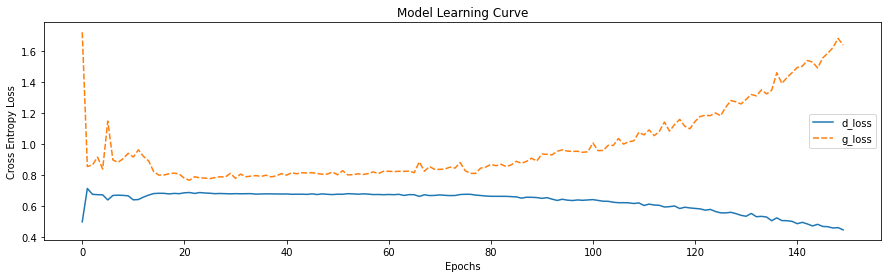

In [25]:
# Plot learning curve

import seaborn as sns
import pandas as pd

history_df = pd.DataFrame(hist.history)
fig = plt.figure(figsize = (15,4))
ax = sns.lineplot(data = history_df)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Cross Entropy Loss")
ax.set_title("Model Learning Curve")

<a id="section-seven"></a>
# <div style="color:#1968b3;display:fill;border-radius:10px;background-color:white"><p style="padding:12px;color:#1968b3"><b>6 | Test out the generator</b></div>

<a id="subsection-six"></a>
## <b><span style='color:#1968b3'>6.1</span> | Generate images</b>

In [27]:
# Loading pre trained model
#generator.load_weights('generator.h5')

# Generating N images 
N = 36

def art_generator(n_images):
    random_latent_vectors = tf.random.normal((N, latent_dim))
    generated_images = generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    
    for i in range(n_images):
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        img.save("FAKE/image0000{:02d}.png".format(i)) 
        
art_generator(N)

Found 10821 files.


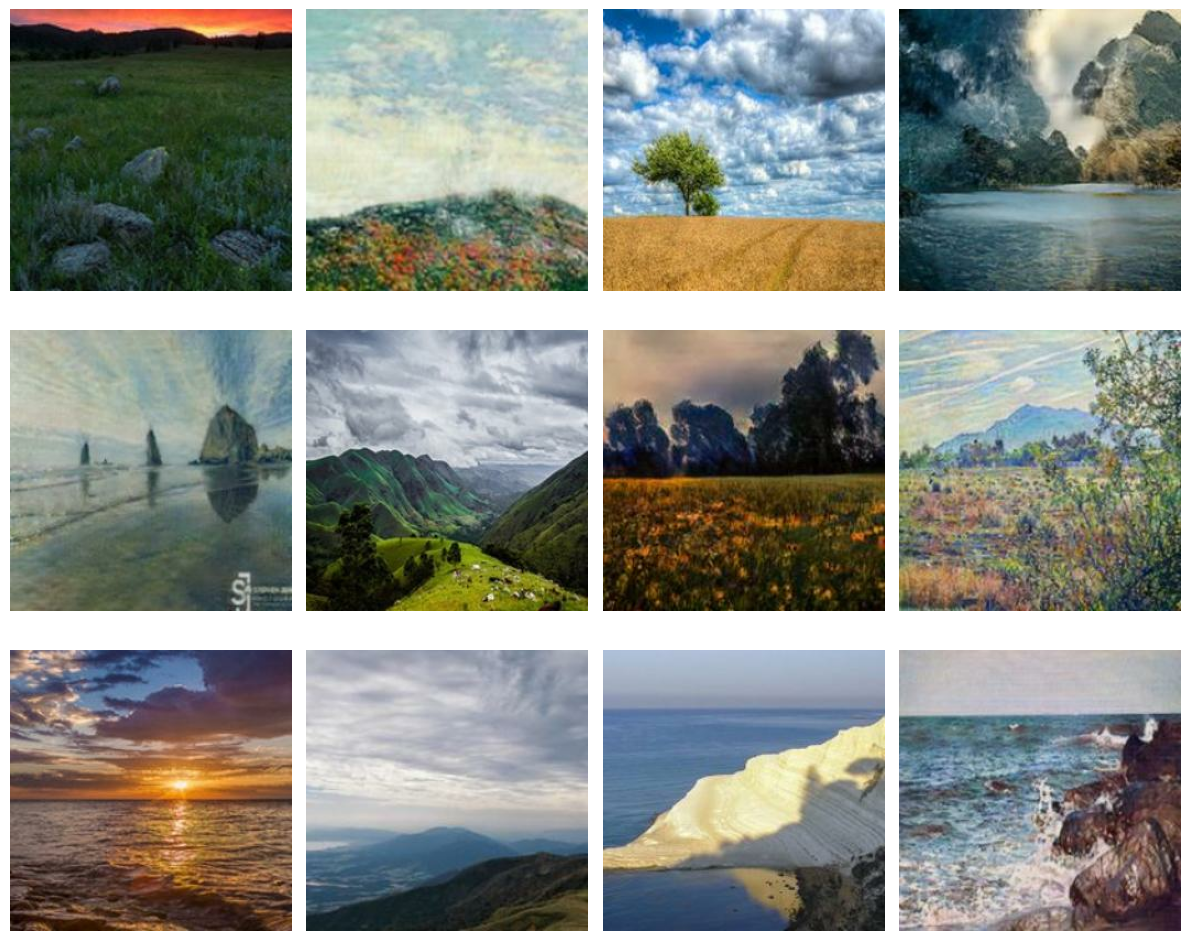

In [22]:
# Loading generated images
generated_path = "./FAKE/"
generated_data = tf.keras.preprocessing.image_dataset_from_directory(generated_path, label_mode = None)

# Visualising generated images
show_images(generated_data)

#### Conclusion:
- The generated images are satisfactory for the current model.
- If higher resolution or better quality is needed, further training is required (e.g., for 256x256 images).
- Increasing the dataset size and cleaning the data can improve training.
- A more robust architecture can always be developed.
- After 150 epochs, the generator and discriminator may start diverging—watch for overfitting.